## Table of Contents

* [Library Import](#library)
* [Data Import](#data_import)
* [Check data integrity](#data_check)
    * [No-template controls (NTC's)](#ntc)
    * [Inter-Run Calibrators (IRC's)](#IRCs)
    * [Failed samples](#fail)  
    * [Outlier identification with reference genes](#outliers)
    * [Check reference gene stability](#ref_genes)
        * [Reference gene statistics](#ref_stats)
    * [Target genes](#target_genes)
        * [Calculate ΔCq & 2^-ΔCq](#delta_Cq)
        * [Plot genes](#target_plots)
        * [Target gene statistics](#target_stats)

## Library import<a class="anchor" id="library"></a>

In [118]:
# pip install jupyterthemes
# pip install scikit_posthocs
# pip install researchpy

In [1]:
# Import libraries
import pandas as pd
from pathlib import Path
import numpy as np
import re

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Import plot libraries
import matplotlib as mpl
import matplotlib.pyplot as pp
import seaborn as sb

# Set custom design for plots
from matplotlib import rc
from jupyterthemes import jtplot
%matplotlib inline
jtplot.style(theme = 'grade3')
jtplot.style(context='paper', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(14, 12))
# jtplot.reset()

sb.color_palette('Accent')

rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

params = {'figure.figsize': (14, 12),
         'axes.labelsize': 14,
         'axes.titlesize': 20,
         'xtick.labelsize':14,
         'ytick.labelsize':14,
         'legend.fontsize': 12,
         'legend.title_fontsize': 'large'}

mpl.rcParams.update(params)
rc('axes', facecolor='#FFFFFF', axisbelow=True, grid=False)
pp.rc('lines', linewidth=2)

# from matplotlib import cycler
# colors = cycler('color',
#                 ['#EE6666', '#66EEEE', '#690202',
#                  '#022869', '#9988DD', '#88BB44'])
# propcycle = colors


# Statistics
from scipy import stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scikit_posthocs as sp
import statsmodels.stats.multicomp as mc
from scipy.stats.mstats import gmean

## Reading in the data <a class="anchor" id="data_import"></a>

Import each plate as csv

Importing as CSV files from biology building computer, therefore it was in Norwegian, so delimiter is ";" and decimal is ",". For some files, I manually edited wells from my computer (if it was easier to just drop the well or rename in the original CSV) so those files still have decimal "," but the delimiter is no longer ";". 

Plates 48, 49, 50 (PRR5 1-3) failed for N13 and I4. 

### Biological Replicate 1 <a class="anchor" id="Biological_Replicate_1"></a>

In [2]:
# Group 1
LHY_1 = pd.read_csv(Path("plate1_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
GAPDH_1 = pd.read_csv(Path("plate2_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR9_1 = pd.read_csv(Path("plate4_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRDX_1 = pd.read_csv(Path("plate5_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
MSI1_1 = pd.read_csv(Path("plate6_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1) 
LUX_1 = pd.read_csv(Path("plate19_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)
PRR7_1 = pd.read_csv(Path("plate21_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)
PRR5_1 = pd.read_csv(Path("plate24_Cq_Results.csv"), decimal = ",", index_col=1)
RVE8_1 = pd.read_csv(Path("plate27_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)
TOC1_1 = pd.read_csv(Path("plate30_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)

# Group 2
LHY_4 = pd.read_csv(Path("plate33_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
GAPDH_4 = pd.read_csv(Path("plate60_Cq_Results.csv"), decimal=",", index_col=1)
PRR9_4 = pd.read_csv(Path("plate39_Cq_Results.csv"), decimal=",", index_col=1)
PRDX_4 = pd.read_csv(Path("plate57_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
MSI1_4 = pd.read_csv(Path("plate45_Cq_Results.csv"), decimal=",",index_col=1) 
LUX_4 = pd.read_csv(Path("plate54_Cq_Results.csv"), decimal=",",index_col=1)
PRR7_4 = pd.read_csv(Path("plate42_Cq_Results.csv"), decimal=",",index_col=1)
RVE8_4 = pd.read_csv(Path("plate36_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)
TOC1_4 = pd.read_csv(Path("plate51_Cq_Results.csv"), decimal=",",index_col=1)

### Biological Replicate 2 <a class="anchor" id="Biological_Replicate_2"></a>

In [3]:
# Group 1
LHY_2 = pd.read_csv(Path("plate7_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
GAPDH_2 = pd.read_csv(Path("plate8_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR9_2 = pd.read_csv(Path("plate10_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRDX_2 = pd.read_csv(Path("plate11_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
MSI1_2 = pd.read_csv(Path("plate12_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
LUX_2 = pd.read_csv(Path("plate20_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR7_2 = pd.read_csv(Path("plate22_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR5_2 = pd.read_csv(Path("plate25_Cq_Results.csv"), decimal = ",", index_col=1)
RVE8_2 = pd.read_csv(Path("plate28_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
TOC1_2 = pd.read_csv(Path("plate31_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)

# Group 2
LHY_5 = pd.read_csv(Path("plate34_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
GAPDH_5 = pd.read_csv(Path("plate61_Cq_Results.csv"), decimal=",", index_col=1)
PRR9_5 = pd.read_csv(Path("plate40_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRDX_5 = pd.read_csv(Path("plate58_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
MSI1_5 = pd.read_csv(Path("plate46_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1) 
LUX_5 = pd.read_csv(Path("plate55_Cq_Results.csv"), decimal=",",index_col=1)
PRR7_5 = pd.read_csv(Path("plate43_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)
RVE8_5 = pd.read_csv(Path("plate37_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)
TOC1_5 = pd.read_csv(Path("plate52_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)

### Biological Replicate 3 <a class="anchor" id="Biological_Replicate_3"></a>

In [4]:
# Group 1
LHY_3 = pd.read_csv(Path("plate13_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
GAPDH_3 = pd.read_csv(Path("plate14_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
LUX_3 = pd.read_csv(Path("plate15_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR9_3 = pd.read_csv(Path("plate16_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRDX_3 = pd.read_csv(Path("plate17_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
MSI1_3 = pd.read_csv(Path("plate18_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR7_3 = pd.read_csv(Path("plate23_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR5_3 = pd.read_csv(Path("plate26_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
RVE8_3 = pd.read_csv(Path("plate29_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
TOC1_3 = pd.read_csv(Path("plate32_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)

# Group 2
LHY_6 = pd.read_csv(Path("plate35_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
GAPDH_6 = pd.read_csv(Path("plate62_Cq_Results.csv"), decimal=",", index_col=1)
PRR9_6 = pd.read_csv(Path("plate41_Cq_Results.csv"), decimal=",", index_col=1)
PRR9_extra_6 = pd.read_csv(Path("plate50_Cq_Results.csv"), decimal=",", index_col=1)
PRDX_6 = pd.read_csv(Path("plate59_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
MSI1_6 = pd.read_csv(Path("plate47_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1) 
LUX_6 = pd.read_csv(Path("plate56_Cq_Results.csv"), decimal=",",index_col=1)
PRR7_6 = pd.read_csv(Path("plate44_Cq_Results.csv"), decimal=",",index_col=1)
RVE8_6 = pd.read_csv(Path("plate38_Cq_Results.csv"), decimal=",",index_col=1)
TOC1_6 = pd.read_csv(Path("plate53_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)

### Data merge and cleanup dataframe

In [5]:
genes_br_1 = [LHY_1, GAPDH_1, PRR9_1, PRDX_1, MSI1_1, LUX_1, PRR7_1, PRR5_1, RVE8_1, TOC1_1, LHY_4, RVE8_4, PRR9_4, PRR7_4, MSI1_4, TOC1_4, LUX_4, GAPDH_4, PRDX_4]

genes_br_2 = [LHY_2, GAPDH_2, PRR9_2, PRDX_2, MSI1_2, LUX_2, PRR7_2, PRR5_2, RVE8_2, TOC1_2, LHY_5, RVE8_5, PRR9_5, PRR7_5, MSI1_5, TOC1_5, LUX_5, PRDX_5, GAPDH_5]

genes_br_3 = [LHY_3, GAPDH_3, LUX_3, PRR9_3, PRDX_3, MSI1_3, PRR7_3, PRR5_3, RVE8_3, TOC1_3, LHY_6, RVE8_6, PRR9_6, PRR7_6, MSI1_6, TOC1_6, LUX_6, PRDX_6, GAPDH_6, PRR9_extra_6]

In [6]:
br_1 = pd.concat(genes_br_1)
br_2 = pd.concat(genes_br_2)
br_3 = pd.concat(genes_br_3)

* Drop all unneccessary columns
* Replace Sample "NaN" with "NTC"
* Replace Cq "NaN" with 0
* Replace "GADPH" with "GAPDH" (typo)
* Change Target "IRC" from "GAPDH" to "IRC" for IRC samples

In [7]:
br_1.reset_index(inplace = True)
br_1.drop(['Well', 'Unnamed: 0',
 'Fluor',
 'Content',
 'Biological Set Name',
 'Cq Mean',
 'Cq Std. Dev',
 'Starting Quantity (SQ)',
 'Log Starting Quantity',
 'SQ Mean',
 'SQ Std. Dev',
 'Set Point',
 'Well Note'], axis=1, inplace = True)

# replace sample NaN name's with NTC
br_1["Sample"] = br_1["Sample"].replace(np.nan, "NTC") 

# replace Cq NaN values with 0
br_1["Cq"] = br_1["Cq"].replace(np.nan, 0) 

 # rename misnamed target's
br_1["Target"].replace({"GADPH":"GAPDH", "qMSI1":"MSI1"}, inplace=True)

# set replicate number for future merged dataframe
br_1['Replicate'] = '1' 

# Set order of columns
br_1 = br_1[['Sample', 'Replicate', 'Target', 'Cq']]

#rename IRC targets for separate use
br_1.loc[br_1["Sample"].str.contains("IRC1"), "Target" ] = "IRC1"
br_1.loc[br_1["Sample"].str.contains("IRC2"), "Target" ] = "IRC2"
br_1.loc[br_1["Sample"].str.contains("IRC3"), "Target" ] = "IRC3"


In [8]:
br_1.loc[br_1['Sample'] == 'I4_3B'] 

,Sample,Replicate,Target,Cq
854,I4_3B,1,LHY,28.967996
935,I4_3B,1,RVE8,28.439062
1015,I4_3B,1,PRR9,25.922230
1095,I4_3B,1,PRR7,26.273794
1174,I4_3B,1,MSI1,29.318290
1206,I4_3B,1,MSI1,0.000000
1253,I4_3B,1,TOC1,28.393389
1332,I4_3B,1,LUX,29.706691
1411,I4_3B,1,GAPDH,22.861219
1486,I4_3B,1,PRDX,22.761280


In [9]:
# Re-did I4_3B_1 MSI1 (plate 45) in well G7, delete the other cell
br_1.drop(1206, axis=0, inplace = True)

In [10]:
br_2.reset_index(inplace = True)
br_2.drop(['Well', 'Unnamed: 0',
 'Fluor',
 'Content',
 'Biological Set Name',
 'Cq Mean',
 'Cq Std. Dev',
 'Starting Quantity (SQ)',
 'Log Starting Quantity',
 'SQ Mean',
 'SQ Std. Dev',
 'Set Point',
 'Well Note'], axis=1, inplace = True)

# Same transformations as br_1
br_2["Sample"] = br_2["Sample"].replace(np.nan, "NTC")
br_2["Cq"] = br_2["Cq"].replace(np.nan, 0)
br_2["Target"].replace({"GADPH":"GAPDH", "qMSI1":"MSI1"}, inplace=True)
br_2['Replicate'] = '2'
br_2 = br_2[['Sample', 'Replicate', 'Target', 'Cq']]
br_2.loc[br_2["Sample"].str.contains("IRC1"), "Target" ] = "IRC1"
br_2.loc[br_2["Sample"].str.contains("IRC2"), "Target" ] = "IRC2"
br_2.loc[br_2["Sample"].str.contains("IRC3"), "Target" ] = "IRC3"

In [11]:
br_2.loc[850, :]

Sample         I4_2B_1
Replicate            2
Target             NaN
Cq           26.357008
Name: 850, dtype: object

In [12]:
# Dont need this sample, accidental re-make
br_2.drop(850, axis=0, inplace=True)

In [13]:
br_3.reset_index(inplace = True)
br_3.drop(['Well', 'Unnamed: 0',
 'Fluor',
 'Content',
 'Biological Set Name',
 'Cq Mean',
 'Cq Std. Dev',
 'Starting Quantity (SQ)',
 'Log Starting Quantity',
 'SQ Mean',
 'SQ Std. Dev',
 'Set Point',
 'Well Note'], axis=1, inplace = True)

# Same transformations as br_1
br_3["Sample"] = br_3["Sample"].replace(np.nan, "NTC")
br_3["Cq"] = br_3["Cq"].replace(np.nan, 0)
br_3["Target"].replace({"GADPH":"GAPDH", "qMSI1":"MSI1"}, inplace=True)
br_3['Replicate'] = '3'
br_3 = br_3[['Sample', 'Replicate', 'Target', 'Cq']]
br_3.loc[br_3["Sample"].str.contains("IRC1"), "Target" ] = "IRC1"
br_3.loc[br_3["Sample"].str.contains("IRC2"), "Target" ] = "IRC2"
br_3.loc[br_3["Sample"].str.contains("IRC3"), "Target" ] = "IRC3"

### Combine all to one dataframe

In [14]:
replicates = [br_1, br_2, br_3]
data = pd.concat(replicates, ignore_index = True)
data

,Sample,Replicate,Target,Cq
0,N2_1A,1,LHY,23.972973
1,N2_2A,1,LHY,22.608713
2,N2_1B,1,LHY,22.410477
3,N2_2B,1,LHY,23.546714
4,N2_3A,1,LHY,21.134845
...,...,...,...,...
4489,I4_13D,3,PRR9,30.051217
4490,NTC,3,PRR9,39.440899
4491,IRC1_50,3,IRC1,21.016340
4492,IRC2_50,3,IRC2,21.970216


In [15]:
# Pullout IRC's for separate use
data = data[~data.Sample.str.contains('IRC')]

Set column names for variables according to dictionary of sample ID

In [16]:
sampleID_treatment = {"A": "Norway", 
                      "B": "Italy", 
                      "C": "D-Norway", 
                      "D": "D-Italy"}

sampleID_zeitgeber = {"_1": "0", "_2": "4", "_3": "8", 
                      "_4": "12", "_5": "16", "_6": "20", 
                      "_7": "24", "_8": "28", "_9": "32", 
                      "_10": "36", "_11": "40", "_12": "44", 
                      "_13": "48"}

sampleID_Clone = {"I1": "I1", "N2": "N2", 
                  "I4": "I4", "N13": "N13"}

In [17]:
data['treatment']= data.Sample.apply(lambda x : 
                                     ''.join([v if k in x  else '' for k,v in sampleID_treatment.items()]))

data['zeitgeber'] = data.Sample.apply(lambda x : 
                                      ''.join([v if k in x  else '' for k,v in sampleID_zeitgeber.items()]))

data['Clone'] = data.Sample.apply(lambda x : 
                                  ''.join([v if k in x  else '' for k,v in sampleID_Clone.items()]))


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4331 entries, 0 to 4490
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sample     4331 non-null   object 
 1   Replicate  4331 non-null   object 
 2   Target     4329 non-null   object 
 3   Cq         4331 non-null   float64
 4   treatment  4331 non-null   object 
 5   zeitgeber  4331 non-null   object 
 6   Clone      4331 non-null   object 
dtypes: float64(1), object(6)
memory usage: 270.7+ KB


In [19]:
data.head()

,Sample,Replicate,Target,Cq,treatment,zeitgeber,Clone
0,N2_1A,1,LHY,23.972973,Norway,0,N2
1,N2_2A,1,LHY,22.608713,Norway,4,N2
2,N2_1B,1,LHY,22.410477,Italy,0,N2
3,N2_2B,1,LHY,23.546714,Italy,4,N2
4,N2_3A,1,LHY,21.134845,Norway,8,N2


## Check data integrity <a class="anchor" id="data_check"></a>

### No-template controls <a class="anchor" id="ntc"></a>

In [20]:
data.loc[(data['Sample']=='NTC') & (data['Cq'] > 0)]

,Sample,Replicate,Target,Cq,treatment,zeitgeber,Clone
1025,NTC,1,PRR9,35.105059,D-Norway,,
1048,NTC,1,PRR9,39.139342,D-Norway,,
1262,NTC,1,TOC1,36.279197,D-Norway,,
1495,NTC,1,PRDX,37.749753,D-Norway,,
1715,NTC,2,PRR9,36.559262,D-Norway,,
3454,NTC,3,MSI1,39.274383,D-Norway,,
3887,NTC,3,RVE8,26.898251,D-Norway,,
4082,NTC,3,PRR7,41.931212,D-Norway,,
4162,NTC,3,MSI1,39.286813,D-Norway,,
4402,NTC,3,PRDX,39.010386,D-Norway,,


PRR9 has likely primer-dimers, high Cq vals. TOC1 and MSI1 have possible primer-dimers as well, or some small amount of non-specific target.. For RVE8 NTC was mislabelled, had sample but I wasn't sure if I added it so I made a new well with the sample and labelled it NTC instead of removing.

Check melt curves 

In [21]:
data.loc[(data['Target']=='PRR9') & (data['Cq'] > 35)]

,Sample,Replicate,Target,Cq,treatment,zeitgeber,Clone
236,I1_13B,1,PRR9,35.379026,Italy,048,I1
237,I1_13C,1,PRR9,35.879865,D-Norway,048,I1
972,N13_1A,1,PRR9,35.173178,Norway,0,N13
983,N13_6B,1,PRR9,35.098362,Italy,20,N13
985,N13_7B,1,PRR9,37.544769,Italy,24,N13
1003,N13_12B,1,PRR9,38.411122,Italy,044,N13
1006,N13_13A,1,PRR9,35.956793,Norway,048,N13
1007,N13_13B,1,PRR9,35.491828,Italy,048,N13
1011,I4_1B,1,PRR9,36.748392,Italy,0,I4
1021,I4_6B,1,PRR9,37.093610,Italy,20,I4


In [22]:
data.loc[(data['Target']=='TOC1') & (data['Cq'] > 35)]

,Sample,Replicate,Target,Cq,treatment,zeitgeber,Clone
782,I1_8A,1,TOC1,39.310573,Norway,28,I1
1262,NTC,1,TOC1,36.279197,D-Norway,,
1265,I4_9A,1,TOC1,35.146323,Norway,32,I4
2255,I1_1B,2,TOC1,37.606885,Italy,0,I1
2695,N13_7B,2,TOC1,38.787735,Italy,24,N13
2701,N13_9B,2,TOC1,35.605565,Italy,32,N13
4171,N13_3B,3,TOC1,36.447834,Italy,8,N13
4228,I4_10C,3,TOC1,37.166448,D-Norway,036,I4
4229,I4_10D,3,TOC1,36.885063,D-Italy,036,I4
4230,I4_11A,3,TOC1,36.641713,Norway,040,I4


In [23]:
data = data[data.Sample != 'NTC']

### Failed wells <a class="anchor" id="fail"></a>

In [24]:
failed_wells = data.loc[data['Cq'] == 0]
failed_wells.sort_values(['Clone', 'Target'])

,Sample,Replicate,Target,Cq,treatment,zeitgeber,Clone
156,I1_13C,1,GAPDH,0.0,D-Norway,048,I1
1655,I1_12B,2,GAPDH,0.0,Italy,044,I1
3127,I1_12A,3,GAPDH,0.0,Norway,044,I1
480,I1_13C,1,LUX,0.0,D-Norway,048,I1
3449,I1_12D,3,MSI1,0.0,D-Italy,044,I1
...,...,...,...,...,...,...,...
3486,N2_11C,3,PRR7,0.0,D-Norway,040,N2
3487,N2_11D,3,PRR7,0.0,D-Italy,040,N2
3647,N2_11D,3,RVE8,0.0,D-Italy,040,N2
764,N2_13B,1,TOC1,0.0,Italy,048,N2


C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


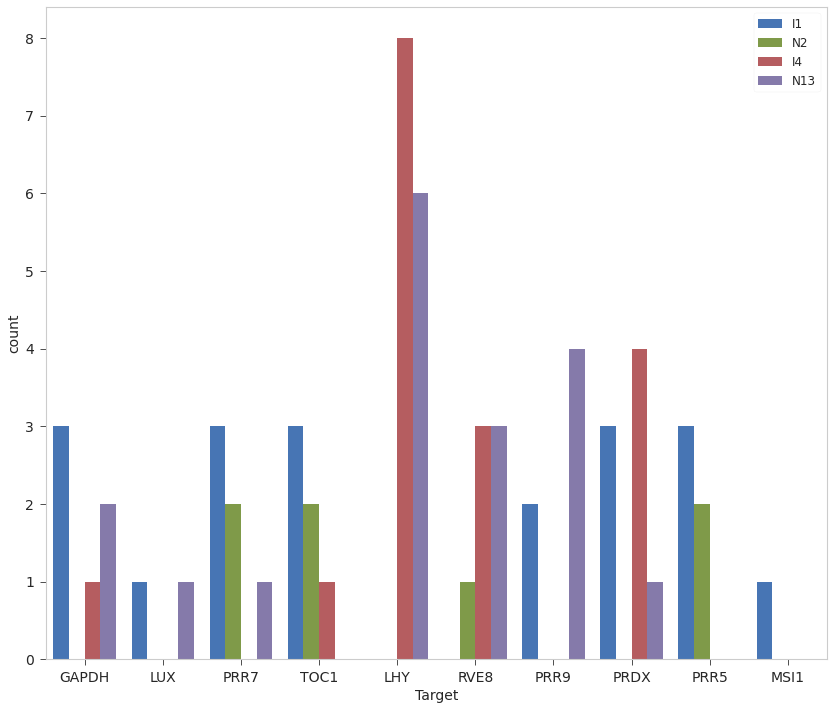

In [25]:
sb.countplot(failed_wells['Target'], hue = failed_wells['Clone'])
pp.legend(loc='upper right')

In [26]:
failed_ref = failed_wells.loc[(failed_wells['Target'] == 'MSI1') | (failed_wells['Target'] == 'GAPDH')]
failed_ref

,Sample,Replicate,Target,Cq,treatment,zeitgeber,Clone
156,I1_13C,1,GAPDH,0.0,D-Norway,048,I1
1655,I1_12B,2,GAPDH,0.0,Italy,044,I1
3127,I1_12A,3,GAPDH,0.0,Norway,044,I1
3449,I1_12D,3,MSI1,0.0,D-Italy,044,I1
4417,N13_6B,3,GAPDH,0.0,Italy,20,N13
4418,N13_7A,3,GAPDH,0.0,Norway,24,N13
4482,I4_13D,3,GAPDH,0.0,D-Italy,048,I4


In [27]:
drop_samps = failed_ref[['Sample', 'Replicate']]

In [28]:
data = data[data.Cq != 0]

## Outlier identification by reference gene Cq values <a class="anchor" id="outliers"></a>

GAPDH         AxesSubplot(0.1,0.15;0.363636x0.75)
MSI1     AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

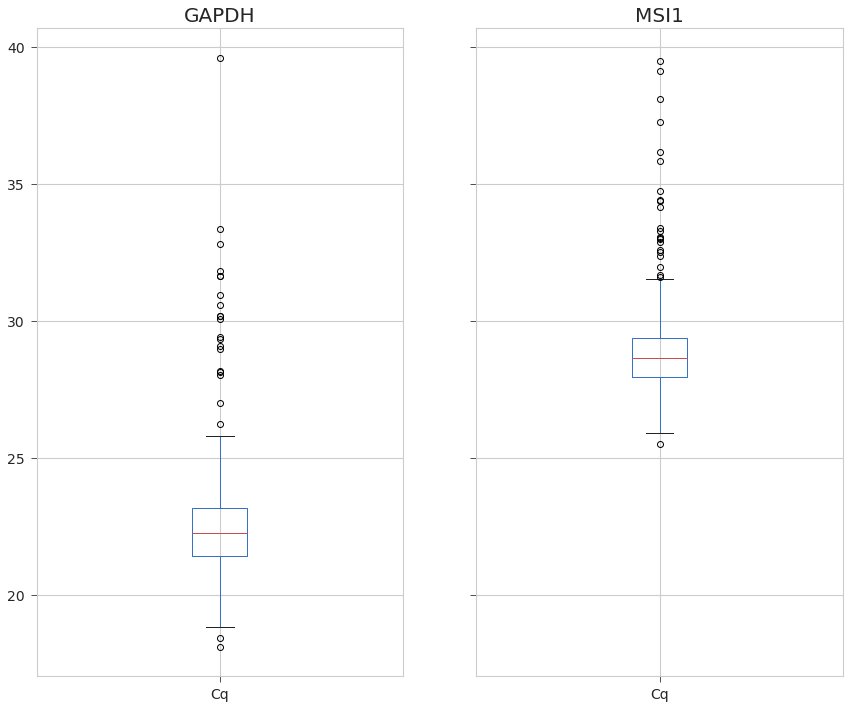

In [29]:
ref_genes = data[(data['Target']=='GAPDH') | (data['Target']=='MSI1')]

ref_genes.groupby('Target').boxplot(column='Cq')

In [30]:
bygene = ref_genes.groupby(by='Target')
bygene.describe()

Cq                                                        \
        count       mean       std        min        25%        50%   
Target                                                                
GAPDH   440.0  22.591800  2.217914  18.114577  21.423183  22.265899   
MSI1    445.0  28.892576  1.695956  25.503145  27.960188  28.663441   

                              
              75%        max  
Target                        
GAPDH   23.191409  39.619334  
MSI1    29.391472  39.503811

In [31]:
GAPDH = data[data['Target']=='GAPDH']
MSI1 = data[data['Target']=='MSI1'] 

In [32]:
def locate_outlier_IQR(df):
    Q1=df['Cq'].quantile(0.25)
    Q3=df['Cq'].quantile(0.75)
    IQR=Q3-Q1
    outliers = df.loc[(df['Cq']>(Q3+1.5*IQR))]
    return (outliers)

In [33]:
GAPDH_outliers = locate_outlier_IQR(GAPDH)
GAPDH_outliers

,Sample,Replicate,Target,Cq,treatment,zeitgeber,Clone
89,N2_5A,1,GAPDH,28.186665,Norway,16,N2
134,I1_8A,1,GAPDH,28.984997,Norway,28,I1
1423,I4_9A,1,GAPDH,30.084437,Norway,32,I4
1428,I4_10B,1,GAPDH,26.242289,Italy,036,I4
1431,I4_11A,1,GAPDH,30.940667,Norway,040,I4
1437,I4_12D,1,GAPDH,29.104890,D-Italy,044,I4
1626,I1_1A,2,GAPDH,30.201841,Norway,0,I1
1627,I1_1B,2,GAPDH,32.805041,Italy,0,I1
1638,I1_7B,2,GAPDH,29.436695,Italy,24,I1
2919,N13_7B,2,GAPDH,39.619334,Italy,24,N13


In [34]:
MSI1_outliers = locate_outlier_IQR(MSI1)
MSI1_outliers

,Sample,Replicate,Target,Cq,treatment,zeitgeber,Clone
332,N2_5A,1,MSI1,31.675457,Norway,16,N2
377,I1_8A,1,MSI1,34.160538,Norway,28,I1
399,I1_13C,1,MSI1,39.121616,D-Norway,048,I1
400,I1_13D,1,MSI1,35.847011,D-Italy,048,I1
1171,I4_2A,1,MSI1,32.391904,Norway,4,I4
1186,I4_9A,1,MSI1,36.163812,Norway,32,I4
1191,I4_10B,1,MSI1,33.028914,Italy,036,I4
1194,I4_11A,1,MSI1,32.896792,Norway,040,I4
1200,I4_12C,1,MSI1,32.523775,D-Norway,044,I4
1871,I1_1B,2,MSI1,37.285711,Italy,0,I1


### Samples to be dropped

In [35]:
High_GAPDH = GAPDH_outliers[['Sample', 'Replicate']]
High_MSI1 = MSI1_outliers[['Sample', 'Replicate']]

drop_refs = pd.concat([High_GAPDH, High_MSI1]).drop_duplicates().reset_index(drop=True)

# Add samples where reference genes failed, nothing to use for relative expression
drop_samples = drop_refs.append(drop_samps).drop_duplicates().reset_index(drop=True)

drop_samples.loc[drop_samples.shape[0]] = ['I4_7B', '2']
drop_samples

,Sample,Replicate
0,N2_5A,1
1,I1_8A,1
2,I4_9A,1
3,I4_10B,1
4,I4_11A,1
5,I4_12D,1
6,I1_1A,2
7,I1_1B,2
8,I1_7B,2
9,N13_7B,2


## Update dataframe

In [36]:
# merge dataframe with dropped samples to identify which are being dropped
data_update = pd.merge(data,drop_samples, on=['Sample', 'Replicate'], 
                 indicator=True, how='outer')

In [37]:
dropped = data_update[data_update['_merge']=='both']
dropped['Sample_ID'] = dropped['Sample'] + dropped['Replicate']
dropped.drop(columns = ['Sample', 'Replicate', '_merge'], inplace = True)
dropped

,Target,Cq,treatment,zeitgeber,Clone,Sample_ID
79,LHY,32.630286,Norway,16,N2,N2_5A1
80,GAPDH,28.186665,Norway,16,N2,N2_5A1
81,PRR9,31.193318,Norway,16,N2,N2_5A1
82,PRDX,29.231520,Norway,16,N2,N2_5A1
83,MSI1,31.675457,Norway,16,N2,N2_5A1
...,...,...,...,...,...,...
4175,MSI1,33.412304,D-Italy,048,N13,N13_13D3
4176,TOC1,33.681369,D-Italy,048,N13,N13_13D3
4177,LUX,34.526111,D-Italy,048,N13,N13_13D3
4178,PRDX,24.903024,D-Italy,048,N13,N13_13D3


In [38]:
dropped_grouped = dropped.groupby('Sample_ID')
rp.summary_cont(dropped_grouped)

Cq                                             
            N     Mean      SD      SE 95% Conf.  Interval
Sample_ID                                                 
I1_12A3     9  27.5905  1.9398  0.6466   26.0995   29.0816
I1_12B2     9  28.3512  3.3344  1.1115   25.7881   30.9142
I1_12D3     9  28.4960  2.4177  0.8059   26.6376   30.3544
I1_13C1     7  37.6289  1.6882  0.6381   36.0676   39.1902
I1_13D1    10  28.9603  3.1594  0.9991   26.7002   31.2204
I1_1A2     10  32.6183  2.3949  0.7573   30.9051   34.3315
I1_1B2      7  35.9340  2.1779  0.8232   33.9198   37.9482
I1_7B2      8  34.9395  3.8929  1.3764   31.6849   38.1941
I1_8A1     10  33.6799  3.4290  1.0843   31.2269   36.1329
I4_10A2     9  34.4329  2.6843  0.8948   32.3696   36.4962
I4_10B1     8  30.9001  3.2815  1.1602   28.1567   33.6435
I4_10C3     7  35.4718  2.2360  0.8451   33.4038   37.5397
I4_11A1     8  34.0300  2.5652  0.9069   31.8854   36.1746
I4_11C2     7  33.9492  2.3170  0.8758   31.8063   36.0921
I4_11D2     8  34.7043  2.9077  1.0280   32.2735   37.1352
I4_12C1     9  32.5561  4.5153  1.5051   29.0853   36.0268
I4_12D1     9  28.9650  2.4819  0.8273   27.0572   30.8728
I4_13D3     6  30.4318  3.5345  1.4429   26.7226   34.1409
I4_2A1      9  30.6137  3.2989  1.0996   28.0780   33.1495
I4_7B2      2  30.9301  7.8815  5.5730  -39.8821  101.7423
I4_9A1      8  33.6854  2.2466  0.7943   31.8073   35.5636
N13_11A3    9  29.2747  2.0599  0.6866   27.6914   30.8580
N13_13D3    7  32.7335  3.5117  1.3273   29.4857   35.9813
N13_3B3     8  33.4524  2.2637  0.8003   31.5599   35.3449
N13_6B3     8  29.4702  3.4288  1.2123   26.6037   32.3367
N13_7A3     8  28.0947  3.0229  1.0687   25.5676   30.6219
N13_7B2     3  39.3036  0.4505  0.2601   38.1845   40.4227
N13_7B3     9  32.3791  4.7952  1.5984   28.6932   36.0650
N13_8B3     9  27.5179  2.5335  0.8445   25.5704   29.4653
N13_9B2     8  33.7440  2.4817  0.8774   31.6692   35.8188
N2_4A3      9  28.3591  2.1548  0.7183   26.7027   30.0154
N2_4B3      9  31.4055  2.8125  0.9375   29.2437   33.5674
N2_5A1     10  32.0950  2.2015  0.6962   30.5201   33.6699

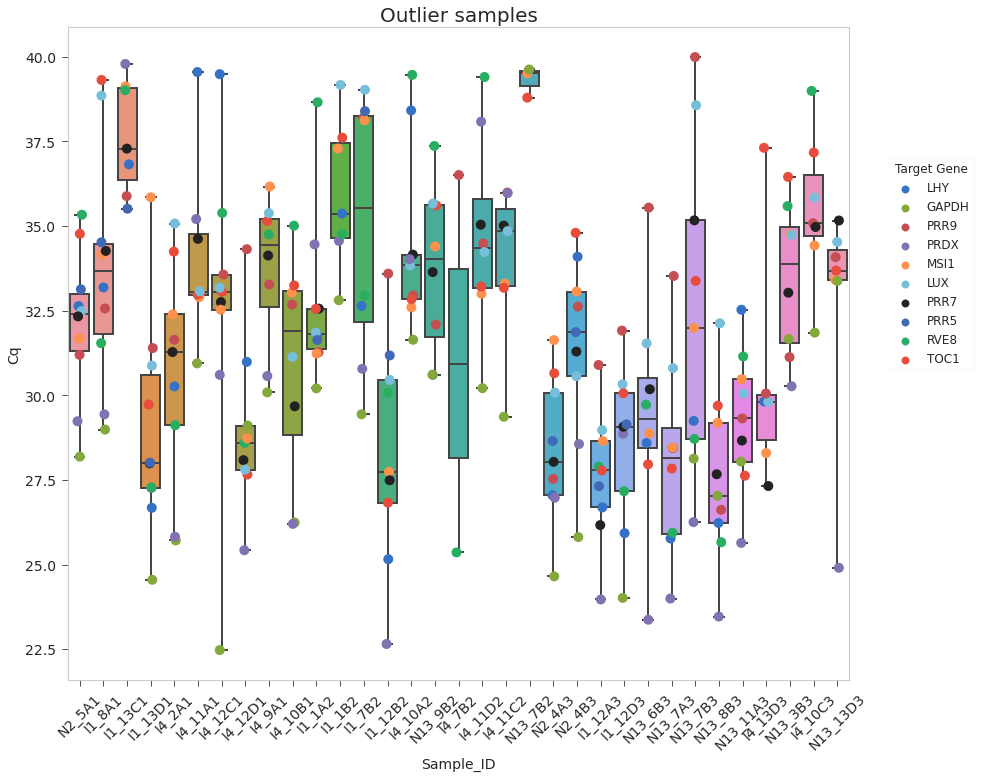

In [39]:
pp.figure()
ax = sb.boxplot(x='Sample_ID', y='Cq', data= dropped, whis=np.inf)
ax = sb.stripplot(x='Sample_ID', y='Cq', data = dropped, jitter=True, hue='Target', size=10) #color = '0.3' for points to be black
pp.xticks(rotation=45)
pp.title('Outlier samples')
ax.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0., title = 'Target Gene')
pp.show()

Remove samples from dataframe

In [40]:
remove_index = data_update[data_update['_merge']=='both'].index
data_update.drop(remove_index, inplace = True)
data_update.drop('_merge', axis=1, inplace = True)

Identify any duplicates

In [41]:
data_update.set_index(['Sample', 'Target', 'Replicate'], drop=True, inplace = True)
data_update

Cq treatment zeitgeber Clone
Sample Target Replicate                                     
N2_1A  LHY    1          23.972973    Norway         0    N2
       GAPDH  1          21.430556    Norway         0    N2
       PRR9   1          32.956244    Norway         0    N2
       PRDX   1          24.378550    Norway         0    N2
       MSI1   1          28.762125    Norway         0    N2
...                            ...       ...       ...   ...
I4_2B  MSI1   3          28.408805     Italy         4    I4
       TOC1   3          28.897120     Italy         4    I4
       LUX    3          31.606425     Italy         4    I4
       PRDX   3          23.439644     Italy         4    I4
       GAPDH  3          21.144145     Italy         4    I4

[3914 rows x 4 columns]

In [42]:
data_update[data_update.index.duplicated()]

Cq treatment zeitgeber Clone
Sample Target Replicate                                     
I1_1A  PRR5   1          30.272990    Norway         0    I1
       PRR7   3          27.708206    Norway         0    I1

## Check stability of reference genes <a class="anchor" id="ref_genes"></a>

In [43]:
data_update.reset_index(inplace=True)

GAPDH = data_update[(data_update['Target']=='GAPDH')]
MSI1 = data_update[(data_update['Target']=='MSI1')] 

In [44]:
# pp.figure()
# sb.boxplot(x='Clone', y='Cq', hue='treatment', data = GAPDH)
# pp.title('GAPDH Cq values by Clone', fontsize = '28')
# pp.show()

In [45]:
# pp.figure()
# sb.boxplot(x='Clone', y='Cq', hue='treatment', data = MSI1)
# pp.title('MSI1 Cq values by Clone', fontsize = '28')
# pp.show()

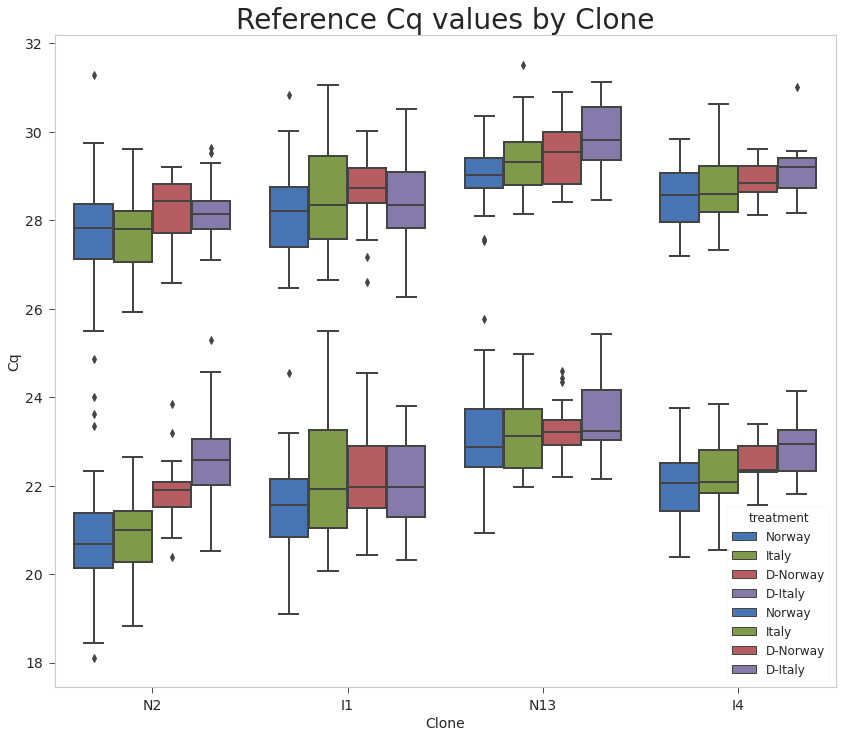

In [46]:
pp.figure()
sb.boxplot(x='Clone', y='Cq', hue='treatment', data = GAPDH)
sb.boxplot(x='Clone', y='Cq', hue='treatment', data = MSI1)
pp.title('Reference Cq values by Clone', fontsize = '28')
pp.show()


# Reference gene statistics <a class="anchor" id="ref_statistics"></a>

### GAPDH

In [47]:
GAPDH_formula = 'Cq ~ C(treatment) + C(Clone) + C(treatment)*C(Clone)'
GAPDH_model = ols(GAPDH_formula, GAPDH).fit()
GAPDH_anova_table = sm.stats.anova_lm(GAPDH_model, typ=2)
GAPDH_anova_table

,sum_sq,df,F,PR(>F)
C(treatment),39.609800,3.0,12.243612,1.117603e-07
C(Clone),197.902090,3.0,61.172649,1.524972e-32
C(treatment):C(Clone),28.438151,9.0,2.930131,2.238464e-03
Residual,429.195250,398.0,NaN,NaN


In [48]:
# Assumption Check - Normality 
GAPDH_res = GAPDH_model.resid
stats.shapiro(GAPDH_model.resid)

ShapiroResult(statistic=0.9863713383674622, pvalue=0.000630443450063467)

<AxesSubplot:>

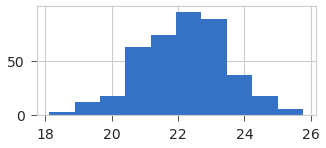

In [49]:
GAPDH['Cq'].hist(figsize=(5,2))

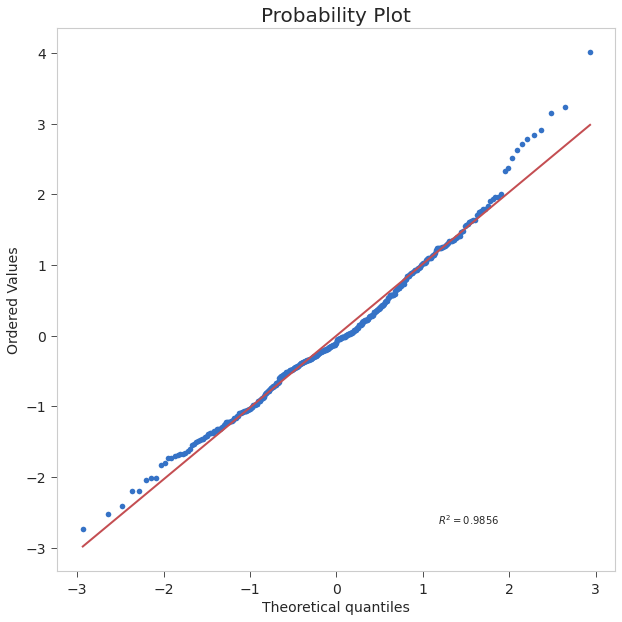

In [50]:
# Assumption Check - Residuals Plot
fig = pp.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

stats.probplot(GAPDH_res, plot=pp,rvalue=True)
pp.show()

In [51]:
GAPDH_groups = GAPDH.Clone.astype(str) + ' ' + GAPDH.treatment.astype(str)

GAPDH_comp = mc.MultiComparison(GAPDH['Cq'], GAPDH_groups)
GAPDH_results = GAPDH_comp.tukeyhsd()
GAPDH_table = pd.DataFrame(data=GAPDH_results._results_table.data[1:], columns=GAPDH_results._results_table.data[0])
GAPDH_sig = GAPDH_table.loc[GAPDH_table['p-adj'] < 0.05, :]
GAPDH_sig

,group1,group2,meandiff,p-adj,lower,upper,reject
7,I1 D-Italy,N13 D-Italy,1.3670,0.0167,0.1197,2.6143,True
13,I1 D-Italy,N2 Italy,-1.2531,0.0061,-2.3204,-0.1859,True
14,I1 D-Italy,N2 Norway,-1.2581,0.0070,-2.3388,-0.1774,True
21,I1 D-Norway,N13 D-Italy,1.3104,0.0236,0.0822,2.5387,True
27,I1 D-Norway,N2 Italy,-1.3097,0.0021,-2.3546,-0.2648,True
28,I1 D-Norway,N2 Norway,-1.3147,0.0024,-2.3733,-0.2561,True
34,I1 Italy,N13 D-Italy,1.2113,0.0098,0.1476,2.2750,True
37,I1 Italy,N13 Norway,0.8719,0.0412,0.0155,1.7283,True
40,I1 Italy,N2 Italy,-1.4089,0.0010,-2.2542,-0.5635,True
41,I1 Italy,N2 Norway,-1.4138,0.0010,-2.2761,-0.5515,True


Significant differences between clones, but also within N2 for D-Italy - Italy and Norway treatment. 

### MSI1

In [52]:
MSI1_formula = 'Cq ~ C(treatment) + C(Clone) + C(treatment)*C(Clone)'
MSI1_model = ols(MSI1_formula, MSI1).fit()
MSI1_anova_table = sm.stats.anova_lm(MSI1_model, typ=2)
MSI1_anova_table

,sum_sq,df,F,PR(>F)
C(treatment),15.192255,3.0,6.300180,3.487206e-04
C(Clone),122.065629,3.0,50.620232,9.830189e-28
C(treatment):C(Clone),6.637079,9.0,0.917459,5.097342e-01
Residual,319.912406,398.0,NaN,NaN


In [53]:
# Assumption Check - Normality 
MSI1_res = MSI1_model.resid
stats.shapiro(MSI1_model.resid)

ShapiroResult(statistic=0.991313636302948, pvalue=0.01572752557694912)

<AxesSubplot:>

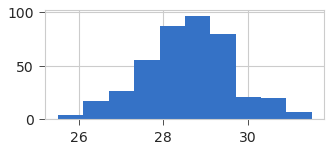

In [54]:
MSI1['Cq'].hist(figsize=(5,2))

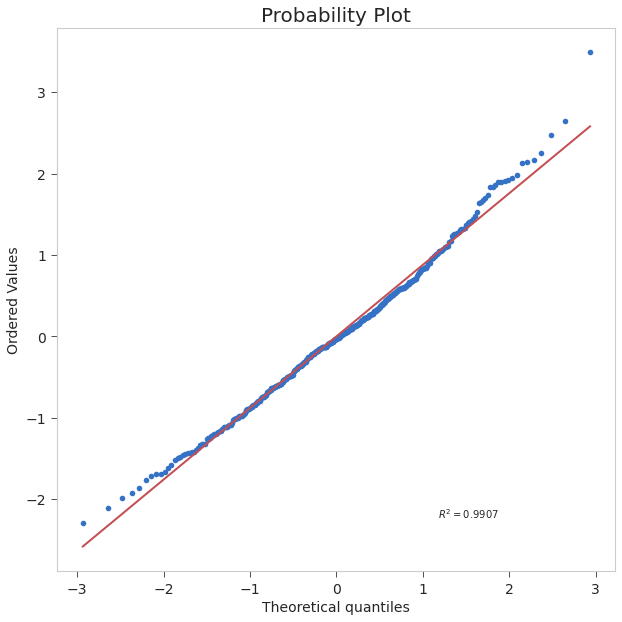

In [55]:
# Assumption Check - Residuals Plot
fig = pp.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

stats.probplot(MSI1_res, plot=pp,rvalue=True)
pp.show()

In [56]:
MSI1_groups = MSI1.Clone.astype(str) + ' ' + MSI1.treatment.astype(str)

MSI1_comp = mc.MultiComparison(MSI1['Cq'], MSI1_groups)
MSI1_results = MSI1_comp.tukeyhsd()
MSI1_table = pd.DataFrame(data=MSI1_results._results_table.data[1:], columns=MSI1_results._results_table.data[0])
MSI1_sig = MSI1_table.loc[MSI1_table['p-adj'] < 0.05, :]
MSI1_sig

,group1,group2,meandiff,p-adj,lower,upper,reject
7,I1 D-Italy,N13 D-Italy,1.5032,0.0010,0.4264,2.5801,True
8,I1 D-Italy,N13 D-Norway,1.1582,0.0213,0.0813,2.2351,True
9,I1 D-Italy,N13 Italy,1.0131,0.0227,0.0665,1.9597,True
21,I1 D-Norway,N13 D-Italy,1.2768,0.0041,0.2164,2.3373,True
27,I1 D-Norway,N2 Italy,-0.9175,0.0416,-1.8196,-0.0154,True
34,I1 Italy,N13 D-Italy,1.2961,0.0010,0.3777,2.2144,True
35,I1 Italy,N13 D-Norway,0.9510,0.0339,0.0327,1.8694,True
36,I1 Italy,N13 Italy,0.8059,0.0260,0.0445,1.5674,True
40,I1 Italy,N2 Italy,-0.8983,0.0028,-1.6281,-0.1684,True
41,I1 Italy,N2 Norway,-0.7878,0.0261,-1.5323,-0.0434,True


Differences in expression of MSI1 between the clones but not within clones, whereas GAPDH differs within clones under the different daylength treatments, so MSI1 should be used as reference for each individual clone. But also could calculate geometric mean and use that as reference?

# Target genes <a class="anchor" id="target_genes"></a>

In [57]:
data2 = data_update.copy()
data2.set_index(["Sample", 'Replicate'], drop=True, inplace = True)
data2

Target         Cq treatment zeitgeber Clone
Sample Replicate                                            
N2_1A  1            LHY  23.972973    Norway         0    N2
       1          GAPDH  21.430556    Norway         0    N2
       1           PRR9  32.956244    Norway         0    N2
       1           PRDX  24.378550    Norway         0    N2
       1           MSI1  28.762125    Norway         0    N2
...                 ...        ...       ...       ...   ...
I4_2B  3           MSI1  28.408805     Italy         4    I4
       3           TOC1  28.897120     Italy         4    I4
       3            LUX  31.606425     Italy         4    I4
       3           PRDX  23.439644     Italy         4    I4
       3          GAPDH  21.144145     Italy         4    I4

[3914 rows x 5 columns]

In [58]:
Target_groups = rp.summary_cont(data2.groupby(['Target', 'Clone']))
Target_groups

Cq                                            
                N     Mean      SD      SE 95% Conf. Interval
Target Clone                                                 
GAPDH  I1     103  22.0013  1.2354  0.1217   21.7599  22.2427
       I4     101  22.2886  0.7842  0.0780   22.1338  22.4434
       N13    102  23.2155  0.9194  0.0910   23.0349  23.3961
       N2     108  21.3001  1.3490  0.1298   21.0427  21.5574
LHY    I1     103  24.4000  2.5816  0.2544   23.8954  24.9045
       I4     100  28.5950  2.0892  0.2089   28.1805  29.0096
       N13    102  28.9779  2.6597  0.2633   28.4555  29.5004
       N2     108  24.1685  2.3705  0.2281   23.7163  24.6207
LUX    I1     102  30.3293  2.0018  0.1982   29.9362  30.7225
       I4     100  30.2230  1.8921  0.1892   29.8476  30.5984
       N13    102  30.8521  1.9552  0.1936   30.4680  31.2361
       N2     107  29.4703  1.7007  0.1644   29.1443  29.7963
MSI1   I1     103  28.4138  1.0963  0.1080   28.1995  28.6280
       I4     101  28.7563  0.7054  0.0702   28.6171  28.8956
       N13    102  29.3784  0.8045  0.0797   29.2204  29.5364
       N2     108  27.8954  0.9859  0.0949   27.7073  28.0834
PRDX   I1     100  24.0162  1.4322  0.1432   23.7321  24.3004
       I4      99  22.8541  1.2884  0.1295   22.5971  23.1111
       N13    102  23.2378  1.6166  0.1601   22.9203  23.5553
       N2     108  24.0160  1.5987  0.1538   23.7111  24.3210
PRR5   I1     102  27.8534  2.6733  0.2647   27.3283  28.3784
       N2     105  27.8651  2.3446  0.2288   27.4114  28.3189
PRR7   I1     103  26.9036  2.0394  0.2009   26.5051  27.3022
       I4     101  27.4284  1.6685  0.1660   27.0990  27.7578
       N13    102  27.9897  1.6946  0.1678   27.6569  28.3226
       N2     105  26.7610  1.7092  0.1668   26.4302  27.0918
PRR9   I1     102  28.8403  3.6225  0.3587   28.1288  29.5518
       I4     101  30.2422  3.2044  0.3189   29.6096  30.8748
       N13    102  30.7252  3.4764  0.3442   30.0424  31.4081
       N2     108  29.0663  3.4721  0.3341   28.4040  29.7287
RVE8   I1     103  27.4419  2.3993  0.2364   26.9730  27.9109
       I4     101  27.8662  1.8444  0.1835   27.5021  28.2303
       N13    101  28.4224  2.5566  0.2544   27.9177  28.9271
       N2     107  27.3369  2.2701  0.2195   26.9017  27.7720
TOC1   I1     102  28.5040  1.2246  0.1212   28.2635  28.7445
       I4     100  28.5179  2.7517  0.2752   27.9719  29.0639
       N13    102  28.2577  1.0514  0.1041   28.0511  28.4642
       N2     106  27.8870  1.1151  0.1083   27.6722  28.1017

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


<Figure size 1008x864 with 0 Axes>

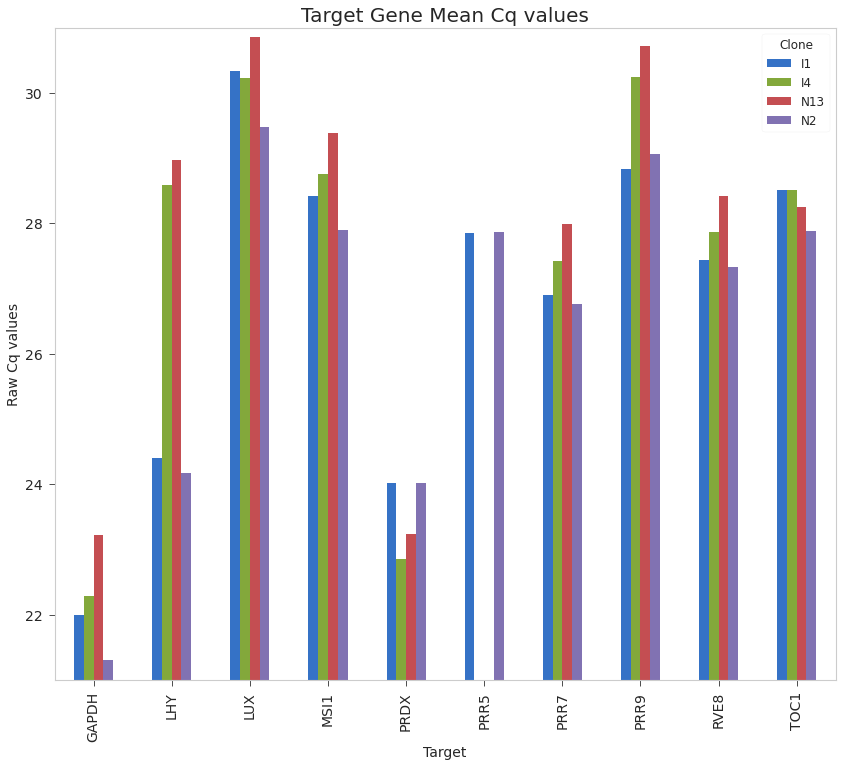

In [59]:
pp.figure()
Target_groups.unstack(level=1).plot(kind ='bar', y = ('Cq',      'Mean'))
pp.ylim(21,31)
pp.ylabel('Raw Cq values')
pp.title('Target Gene Mean Cq values')
pp.show()

Mean Cq values for N13 and I4 are higher than N2 and I1 across the board. They were done a year later, but RNA extraction, cDNA synthesis, and qPCR primer master mixes were all made in the same way. Natural error may have occured due to time between extraction. Possibilities include degredation of tissue in -80C for 1 year (not likely), variation in volumes of cDNA synthesis due to pipette errors (possible), variation in qPCR master mix due to volume used/pipette error (l=possible). 

## Transforming data - Calculate ΔCq & 2 <sup>-ΔCq <a class="anchor" id="delta_Cq"></a>

<AxesSubplot:>

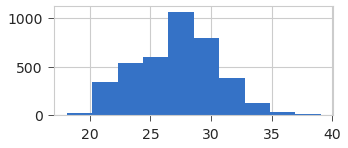

In [60]:
data2['Cq'].hist(figsize=(5,2))

Calculate delta Cq from geometric mean of two reference genes: MSI1 and GAPDH

## ΔCq 

#### Target gene (Cq) - Reference gene (geometric mean of Cq)

In [61]:
def apply_delta_Cq_geom(df, ref1, ref2):
    
    '''Determines delta Cq of each sample based on reference gene geometric mean 
    
    df: Dataframe with index: sample, columns: Target, Cq
    
    ref: reference gene to use for calculation. Must be a string
    
    '''
    ref_gene = df[(df['Target']==ref1) | (df['Target']==ref2)]

    ref_gene.reset_index(inplace=True)
    ref_gene.set_index(['Sample', 'Replicate', 'Target'], inplace = True)
    ref_gene = ref_gene.unstack(level=2)

    # Get geometric mean of reference genes
    ref_gene[(       'Cq', 'gmean')] = gmean([ref_gene[(       'Cq', ref1)], 
                                                            ref_gene[(       'Cq',  ref2)]])
    ref_gene = ref_gene.stack(level=1)
    ref_gene.reset_index(inplace=True)
    ref_gene.set_index(['Sample', 'Replicate'], inplace = True)
    
    # Subtract geometric mean from target Cq values
    df.sort_index(inplace=True)
    d2 = (df.Cq - ref_gene.loc[ref_gene['Target']=='gmean']['Cq'])
    df['delta_Cq'] = d2.values

    return df

In [62]:
apply_delta_Cq_geom(data2, 'GAPDH', 'MSI1')

Target         Cq treatment zeitgeber Clone  delta_Cq
Sample Replicate                                                      
I1_10A 1            LHY  24.282946    Norway       036    I1  0.378490
       1          GAPDH  21.278777    Norway       036    I1 -2.625678
       1           PRR9  24.430283    Norway       036    I1  0.525827
       1           PRDX  22.831522    Norway       036    I1 -1.072934
       1           MSI1  26.854128    Norway       036    I1  2.949672
...                 ...        ...       ...       ...   ...       ...
N2_9D  3           MSI1  28.106467   D-Italy        32    N2  3.788659
       3           PRR7  27.157224   D-Italy        32    N2  2.839416
       3           PRR5  27.408761   D-Italy        32    N2  3.090953
       3           RVE8  24.546936   D-Italy        32    N2  0.229128
       3           TOC1  28.409097   D-Italy        32    N2  4.091289

[3914 rows x 6 columns]

In [65]:
data2['2delta_Cq'] = data2['delta_Cq'].apply(lambda x: 2 ** -(x))
data2.to_csv('qPCR_data_final.csv', index = True)

<AxesSubplot:>

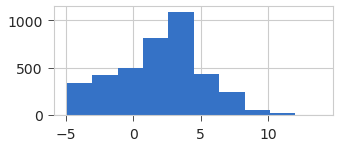

In [66]:
data2['delta_Cq'].hist(figsize=(5,2))

<AxesSubplot:>

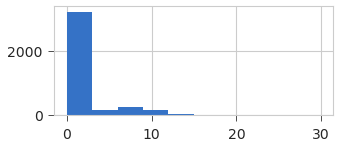

In [67]:
data2['2delta_Cq'].hist(figsize=(5,2))

#### Set zeitgeber as index, 0-48

In [68]:
data2.reset_index(inplace=True)
data2.zeitgeber = pd.to_numeric(data2.zeitgeber)
data2.sort_values(["zeitgeber", 'Sample', 'Replicate'], inplace = True)
data2.set_index('zeitgeber', inplace=True)

Drop Reference genes

In [69]:
data2 = data2[data2.Target != 'GAPDH']
data2 = data2[data2.Target != 'MSI1']

## Visualizing data

In [70]:
rp.summary_cont(data2.groupby("Replicate"))

Cq                                             delta_Cq          \
              N     Mean      SD      SE 95% Conf. Interval        N    Mean   
Replicate                                                                      
1          1056  27.6400  3.1526  0.0970   27.4496  27.8303     1056  2.4676   
2          1007  27.5469  3.1412  0.0990   27.3527  27.7412     1007  2.4608   
3          1023  27.6950  3.1273  0.0978   27.5031  27.8869     1023  2.5057   

                                             2delta_Cq                  \
               SD      SE 95% Conf. Interval         N    Mean      SD   
Replicate                                                                
1          2.9849  0.0919    2.2874   2.6479      1056  1.1388  2.7520   
2          3.0408  0.0958    2.2727   2.6488      1007  1.4655  4.1219   
3          2.9829  0.0933    2.3227   2.6887      1023  0.8710  1.9346   

                                      
               SE 95% Conf. Interval  
Replicate                             
1          0.0847    0.9726   1.3050  
2          0.1299    1.2106   1.7204  
3          0.0605    0.7523   0.9897

In [71]:
rp.summary_cont(data2.groupby("Target"))

Cq                                             delta_Cq          \
          N     Mean      SD      SE 95% Conf. Interval        N    Mean   
Target                                                                     
LHY     413  26.4858  3.3174  0.1632   26.1649  26.8067      413  1.3026   
LUX     411  30.2096  1.9468  0.0960   30.0208  30.3983      411  5.0192   
PRDX    409  23.5408  1.5704  0.0777   23.3881  23.6934      409 -1.6438   
PRR5    207  27.8593  2.5058  0.1742   27.5160  28.2027      207  3.1986   
PRR7    411  27.2657  1.8431  0.0909   27.0870  27.4444      411  2.0763   
PRR9    413  29.7078  3.5247  0.1734   29.3668  30.0487      413  4.5253   
RVE8    412  27.7590  2.3148  0.1140   27.5348  27.9832      412  2.5804   
TOC1    410  28.2866  1.6917  0.0835   28.1223  28.4508      410  3.1001   

                                          2delta_Cq                          \
            SD      SE 95% Conf. Interval         N    Mean      SD      SE   
Target                                                                        
LHY     2.8348  0.1395    1.0284   1.5768       413  1.9030  3.6907  0.1816   
LUX     1.8597  0.0917    4.8389   5.1996       411  0.0609  0.0685  0.0034   
PRDX    1.5512  0.0767   -1.7946  -1.4931       409  5.3648  5.8307  0.2883   
PRR5    2.3465  0.1631    2.8770   3.5201       207  0.2669  0.3197  0.0222   
PRR7    1.6704  0.0824    1.9143   2.2383       411  0.3971  0.3753  0.0185   
PRR9    3.2508  0.1600    4.2109   4.8397       413  0.2628  0.4673  0.0230   
RVE8    2.1986  0.1083    2.3675   2.7933       412  0.4008  0.4823  0.0238   
TOC1    1.7309  0.0855    2.9321   3.2682       410  0.1757  0.1633  0.0081   

                           
       95% Conf. Interval  
Target                     
LHY       1.5460   2.2600  
LUX       0.0543   0.0676  
PRDX      4.7981   5.9316  
PRR5      0.2231   0.3107  
PRR7      0.3607   0.4335  
PRR9      0.2176   0.3080  
RVE8      0.3541   0.4475  
TOC1      0.1598   0.1916

In [72]:
data2.reset_index(inplace = True)

In [73]:
data2.groupby('zeitgeber')['2delta_Cq']

In [74]:
data2.loc[(data2['Target'] == 'LHY') & (data2['zeitgeber'] == 0)]

,zeitgeber,Sample,Replicate,Target,Cq,treatment,Clone,delta_Cq,2delta_Cq
0,0,I1_1A,1,LHY,21.915832,Norway,I1,-2.688863,6.448049
9,0,I1_1A,3,LHY,22.825598,Norway,I1,-2.270565,4.825120
17,0,I1_1B,1,LHY,22.353653,Italy,I1,-3.354785,10.230363
25,0,I1_1B,3,LHY,21.076841,Italy,I1,-3.822368,14.146445
33,0,I4_1A,1,LHY,28.724719,Norway,I4,3.026644,0.122713
40,0,I4_1A,2,LHY,28.626595,Norway,I4,2.001607,0.249722
47,0,I4_1A,3,LHY,27.002453,Norway,I4,1.562800,0.338493
54,0,I4_1B,1,LHY,27.865699,Italy,I4,0.844504,0.556902
61,0,I4_1B,2,LHY,26.026170,Italy,I4,0.271784,0.828295
68,0,I4_1B,3,LHY,25.727937,Italy,I4,0.393468,0.761298


In [1]:
# zt = data2.index.unique()
# targets = data2.Target.unique()
# corr = data2.corr()

# # rotate the labels by 90 degree to fit the names
# pp.xticks(ticks=np.arange(len(zt)),labels=zt,rotation=90)
# # Setting the labels of y axis.
# # set the xticks as subject-names
# pp.yticks(ticks=np.arange(len(targets)),labels=targets)
# # use the imshow function to generate a heatmap
# # cmap parameter gives color to the graph
# # setting the interpolation will lead to different types of graphs
# hm = pp.imshow(corr, cmap='cool',interpolation="nearest")
# pp.colorbar(hm)

# Plot target genes 2<sup>-ΔCq <a class="anchor" id="target_plots"></a>

1. pull data for target 
2. Groupby treatment
3. Make separate treatment groups (Norway, D) & (Italy, D)
4. groupby zeitgeber, clone (Sample)
5. get mean and std of 2deltaCq values for groupby


6. plot those values where
    x = zeitgeber
    y = 2delta_Cq agg function values from groupby of zeitgeber, sample?
    ax.errorbar

In [76]:
def plot_gene(df, target_gene):
    
    
    '''Plot data for specified target gene

    Groups data by two treatments (Italy, and Norway) including respective dark treatments.
    
    :param df: DataFrame
    :param target_gene: gene name to pull from targets
    :return: 2 figures for gene and treatments
    '''  
    # Set figure to have 2 subplots
    fig, (ax1, ax2) = pp.subplots(2, 1, figsize = (16,14)) 
    
    #Pull data for specified target gene from dataframe
    gene_data = df.loc[df['Target']==target_gene] 
    
    #Set label for treatment names for legend
    legend_dict = {'D-Italy': '-D', 'D-Norway' : '-D', 'Italy': ' ', 'Norway': ' '}
    
    # Plot Italy on ax1, Norway on ax2
    It = gene_data[gene_data['treatment'].str.contains('Italy')] 
    It_groups = It.groupby('treatment')

    for name, group in It_groups: # name = treatment group = data for treatment
        
        #groupby sample within treatment
        It_result = group.groupby(['zeitgeber', 'Clone']).agg({'2delta_Cq' : ['mean', 'std']}) 
        # Zeitgebers for x-axis
        It_x = It_result.index.levels[0]
        # Clones for separate y-values
        It_clones = It_result.index.levels[1]  

        for clone in It_clones:
            
            # Pulls mean 2^-Cq for each clone & zeitgeber (y-values)
            It_avg_data = It_result.loc[[(zeitgeber, clone) for zeitgeber in It_x], ('2delta_Cq', 'mean')] 
            # Pulls std of mean 2^-Cq for each clone & zeitgeber 
            It_err_data = It_result.loc[[(zeitgeber, clone) for zeitgeber in It_x], ('2delta_Cq',  'std')] 
            
            # Set label names to legend items for legend 
            label1 = ""
            if name in legend_dict.keys():
                label1 = str(legend_dict[name])
            else: label1= ' '
            
            It_plot = ax1.errorbar(It_x, It_avg_data, yerr = It_err_data, fmt = '-o', 
                                   label = str(clone) + str(label1))
            
            #Plot Italy treatments
            ax1.set_xticks(It_x)
            ax1.set_title('Italy', x=0.05, y=0.9, fontsize = '20')
            ax1.set_ylabel("Relative Expression")     
            
    # Plotting Norway ax2
    No = gene_data[gene_data['treatment'].str.contains('Norway')] 
    No_groups = No.groupby('treatment')
    
    for name, group in No_groups:
        Norway_result = group.groupby(['zeitgeber', 'Clone']).agg({'2delta_Cq' : ['mean', 'std']})
        No_x = Norway_result.index.levels[0]
        No_clones = Norway_result.index.levels[1]

        for clone in No_clones:
            No_avg_data = Norway_result.loc[[(zeitgeber, clone) for zeitgeber in No_x], ('2delta_Cq', 'mean')] 
            No_err_data = Norway_result.loc[[(zeitgeber, clone) for zeitgeber in No_x], ('2delta_Cq',  'std')] 
            
            label2 = ""
            if name in legend_dict.keys():
                label2 = str(legend_dict[name])
            else: label2= ' '
                
            No_plot = ax2.errorbar(No_x, No_avg_data, No_err_data, fmt = '-o',
                                  label = str(clone) + str(label2))
            ax2.set_xticks(No_x)
            ax2.set_title('Norway', x=0.05, y=0.9, fontsize = '20')
            ax2.set_xlabel("Zeitgeber")
            ax2.set_ylabel("Relative Expression")

    ax1.legend(bbox_to_anchor=(1.05, 0.25), loc=2, borderaxespad=0., title = 'Clone')
    fig.suptitle(t = target_gene, fontsize = '36')
    pp.savefig(target_gene + "expression.png", dpi=300, bbox_inches='tight')
    return fig, (ax1, ax2)



In [77]:
def clone_hist(df, target_gene):
    
    figure = pp.figure(figsize = (10,2))
    target_data = df[df['Target']==target_gene]
    target_data.reset_index(inplace=True)
    
    x1 = target_data.loc[target_data.Clone=='I1', '2delta_Cq']
    x2 = target_data.loc[target_data.Clone=='I4', '2delta_Cq']
    x3 = target_data.loc[target_data.Clone=='N2', '2delta_Cq']
    x4 = target_data.loc[target_data.Clone=='N13', '2delta_Cq']

    kwargs = dict(alpha=0.5, bins=100)

    pp.hist(x1, **kwargs, color='g', label='I1')
    pp.hist(x2, **kwargs, color='b', label='I4')
    pp.hist(x3, **kwargs, color='r', label='N2')
    pp.hist(x4, **kwargs, color='y', label='N13')
    
    pp.gca().set(title='Frequency Histogram of Clones for ' + target_gene + " 2^(-delta Cq) values", ylabel='Frequency')
    pp.legend();
    
    return(pp.show())

In [78]:
def anova_gene(df, target_gene):
    
    target_gene_data = data2[data2['Target']==target_gene]
    target_gene_data.reset_index(inplace=True)
    
    gene_formula = 'Q("2delta_Cq")' + '~ C(treatment, Sum) + C(zeitgeber, Sum) + C(Clone, Sum) + C(Clone, Sum):C(zeitgeber, Sum) + C(treatment, Sum):C(zeitgeber, Sum) '

    target_gene_model = ols(gene_formula, data=target_gene_data).fit()
    target_gene_aov = sm.stats.anova_lm(target_gene_model, typ=3)
    
    target_gene_groups = 'zt' + target_gene_data.zeitgeber.astype(str) + ', ' + target_gene_data.treatment.astype(str)

    target_gene_z_comp = mc.MultiComparison(target_gene_data['2delta_Cq'], target_gene_groups)
    target_gene_z_ph = target_gene_z_comp.tukeyhsd()
    target_gene_table = pd.DataFrame(data=target_gene_z_ph._results_table.data[1:], columns=target_gene_z_ph._results_table.data[0])
    target_gene_sig = target_gene_table.loc[target_gene_table['p-adj'] < 0.05, :]
    
    return(target_gene_sig)

In [79]:
def treatment_ttest(df, target_gene):


    gene_data = df[df['Target']== target_gene]
    gene_data.reset_index(inplace=True)

    gene_stats = gene_data.groupby(["zeitgeber", "Clone"]).apply(lambda gene_data:
                                                               stats.ttest_ind(gene_data.loc[gene_data['treatment'] == 'Norway']['2delta_Cq'], 
                                                                              gene_data.loc[gene_data['treatment'] == 'Italy']['2delta_Cq']))

    gene_stats= gene_stats.to_frame()
    gene_stats.columns = ["Value"]
    gene_stats= pd.DataFrame(gene_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = gene_stats.index)
    gene_sig = gene_stats.loc[gene_stats["p-value"] < 0.05]

    return(gene_sig)

In [80]:
def dark_norway_ttest(df, target_gene):


    gene_data = df[df['Target']== target_gene]
    gene_data.reset_index(inplace=True)

    gene_stats = gene_data.groupby(["zeitgeber", "Clone"]).apply(lambda gene_data:
                                                               stats.ttest_ind(gene_data.loc[gene_data['treatment'] == 'Norway']['2delta_Cq'], 
                                                                              gene_data.loc[gene_data['treatment'] == 'D_Norway']['2delta_Cq']))

    gene_stats= gene_stats.to_frame()
    gene_stats.columns = ["Value"]
    gene_stats= pd.DataFrame(gene_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = gene_stats.index)
    gene_sig = gene_stats.loc[gene_stats["p-value"] < 0.05]

    return(gene_sig)

In [81]:
def dark_italy_ttest(df, target_gene):


    gene_data = df[df['Target']== target_gene]
    gene_data.reset_index(inplace=True)

    gene_stats = gene_data.groupby(["zeitgeber", "Clone"]).apply(lambda gene_data:
                                                               stats.ttest_ind(gene_data.loc[gene_data['treatment'] == 'Italy']['2delta_Cq'], 
                                                                              gene_data.loc[gene_data['treatment'] == 'D_Italy']['2delta_Cq']))

    gene_stats= gene_stats.to_frame()
    gene_stats.columns = ["Value"]
    gene_stats= pd.DataFrame(gene_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = gene_stats.index)
    gene_sig = gene_stats.loc[gene_stats["p-value"] < 0.05]

    return(gene_sig)

In [82]:
def clone_ttest(df, target_gene):


    gene_data = df[df['Target']== target_gene]
    gene_data.reset_index(inplace=True)

    gene_stats = gene_data.groupby(["zeitgeber", "treatment"]).apply(lambda gene_data:
                                                               stats.ttest_ind(gene_data.loc[gene_data['Clone'].str.contains('I')]['2delta_Cq'], 
                                                                              gene_data.loc[gene_data['Clone'].str.contains('N')]['2delta_Cq']))

    gene_stats= gene_stats.to_frame()
    gene_stats.columns = ["Value"]
    gene_stats= pd.DataFrame(gene_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = gene_stats.index)
    gene_sig = gene_stats.loc[gene_stats["p-value"] < 0.05]

    return(gene_sig)

## LHY

(<Figure size 1152x1008 with 2 Axes>,
 (<AxesSubplot:title={'center':'Italy'}, ylabel='Relative Expression'>,
  <AxesSubplot:title={'center':'Norway'}, xlabel='Zeitgeber', ylabel='Relative Expression'>))

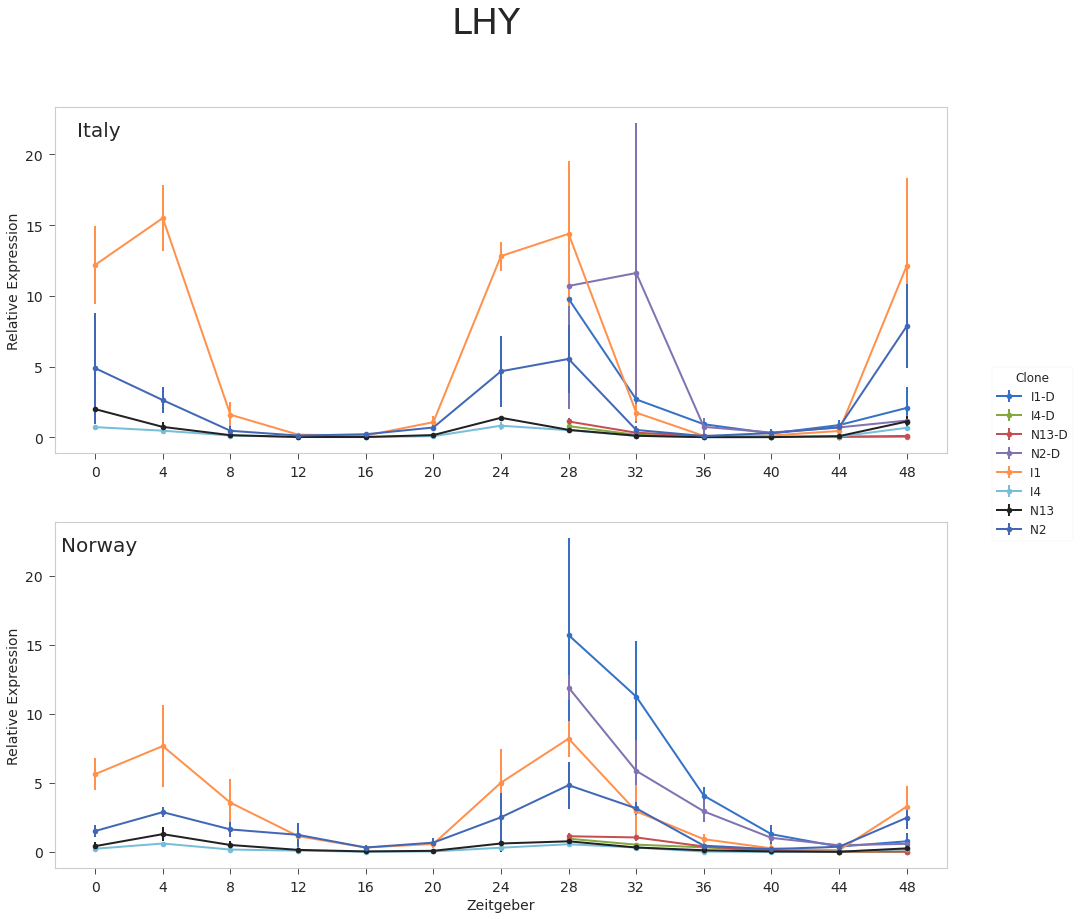

In [83]:
plot_gene(data2, 'LHY')

In [84]:
treatment_ttest(data2, 'LHY')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
zeitgeber Clone                     
0         I4     -4.651565  0.009650
8         N2      3.189549  0.033231
12        I4     16.404168  0.000081
          N13     4.077365  0.015131
16        I1      3.605703  0.022643
24        I1     -4.087978  0.026454
32        I4      8.540902  0.003372
          N2      8.780231  0.000928
36        I4      4.501700  0.045970
          N13     4.602417  0.010013
          N2      6.305560  0.008060
40        N13     3.723024  0.033737
44        I1    -75.349221  0.000176
          N13    -2.814165  0.048113
48        I4     -4.056043  0.015399
          N13    -3.401957  0.027228
          N2     -3.050301  0.038017

In [85]:
dark_norway_ttest(data2, 'LHY')

,,Ttest_ind,p-value
zeitgeber,Clone,,


In [86]:
dark_italy_ttest(data2, 'LHY')

,,Ttest_ind,p-value
zeitgeber,Clone,,


In [87]:
clone_ttest(data2, 'LHY')

,,Ttest_ind,p-value
zeitgeber,treatment,,


## RVE8

(<Figure size 1152x1008 with 2 Axes>,
 (<AxesSubplot:title={'center':'Italy'}, ylabel='Relative Expression'>,
  <AxesSubplot:title={'center':'Norway'}, xlabel='Zeitgeber', ylabel='Relative Expression'>))

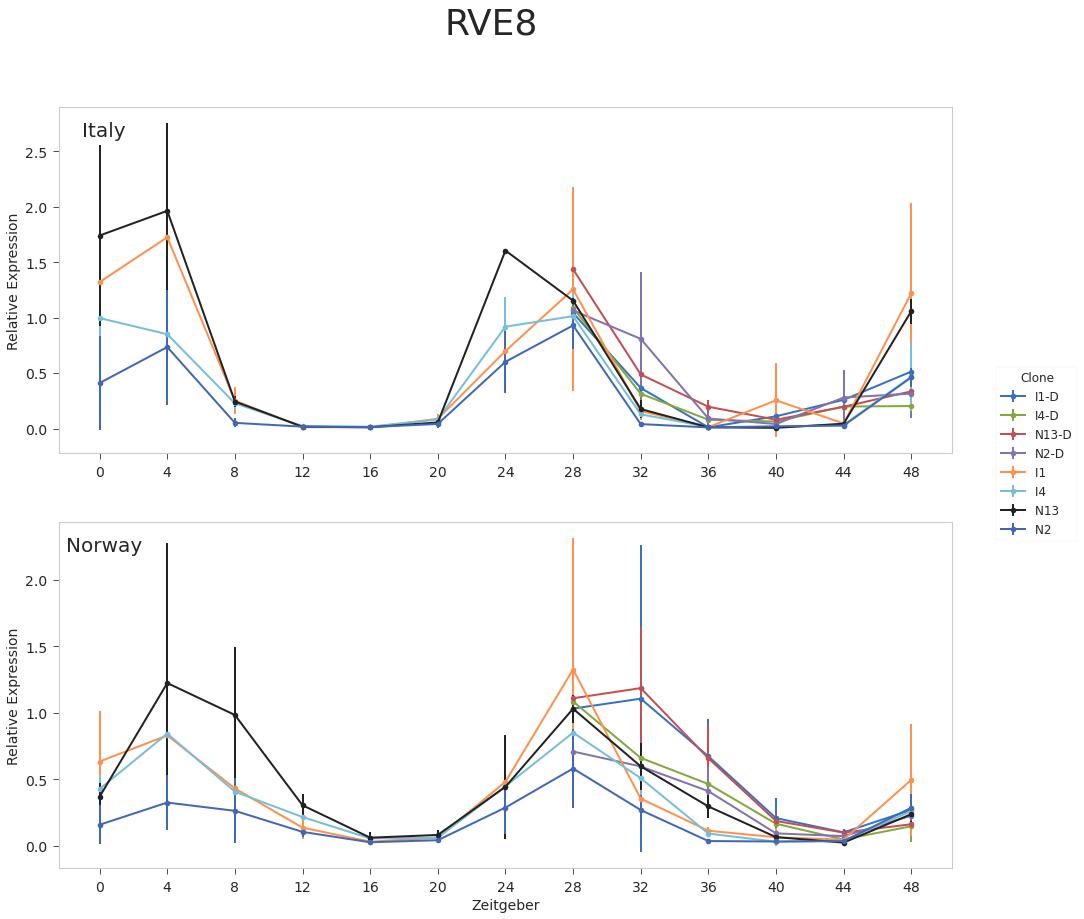

In [88]:
plot_gene(data2, 'RVE8')

In [89]:
RVE8_data = data2[data2['Target']=='RVE8']
rp.summary_cont(RVE8_data['2delta_Cq'].groupby(RVE8_data['Clone']))

,N,Mean,SD,SE,95% Conf.,Interval
Clone,,,,,,
I1,103,0.4505,0.5538,0.0546,0.3422,0.5587
I4,101,0.3570,0.3710,0.0369,0.2837,0.4302
N13,101,0.5111,0.5937,0.0591,0.3939,0.6283
N2,107,0.2902,0.3411,0.0330,0.2249,0.3556


In [90]:
treatment_ttest(data2, 'RVE8')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
zeitgeber Clone                     
0         I4     -2.904955  0.043899
4         I1     -5.929529  0.009586
8         I4      4.260369  0.013050
12        I4     16.264132  0.000084
          N13     6.076069  0.003707
16        I1      2.954169  0.041796
32        I4      4.474545  0.020805
          N2      3.401239  0.027246
36        I1      4.275716  0.023492
          I4      5.845717  0.028038
          N13     4.558686  0.019788
          N2     13.939152  0.000799
40        I4      3.832481  0.031308
          N13     4.185700  0.024855
44        N13    -6.452561  0.002970
48        N13   -10.000070  0.000562

In [91]:
dark_norway_ttest(data2, 'RVE8')

,,Ttest_ind,p-value
zeitgeber,Clone,,


In [92]:
dark_italy_ttest(data2, 'RVE8')

,,Ttest_ind,p-value
zeitgeber,Clone,,


In [93]:
clone_ttest(data2, 'RVE8')

,,Ttest_ind,p-value
zeitgeber,treatment,,
36,D-Italy,-2.729183,0.021223


## PRR9

(<Figure size 1152x1008 with 2 Axes>,
 (<AxesSubplot:title={'center':'Italy'}, ylabel='Relative Expression'>,
  <AxesSubplot:title={'center':'Norway'}, xlabel='Zeitgeber', ylabel='Relative Expression'>))

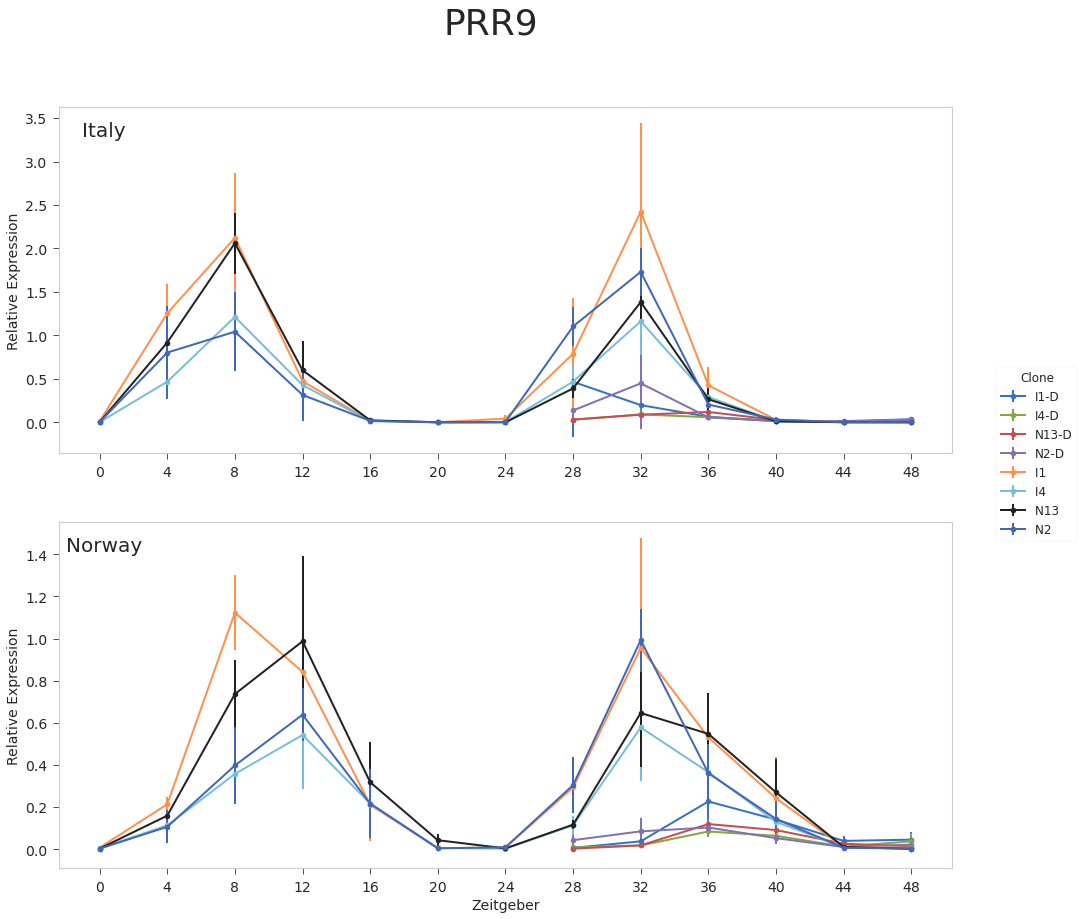

In [94]:
plot_gene(data2, 'PRR9')

In [95]:
treatment_ttest(data2, 'PRR9')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
zeitgeber Clone                     
4         I1     -5.867484  0.009873
          I4     -7.638026  0.004660
          N13    -4.793317  0.017273
8         I4     -4.430190  0.011420
          N13    -5.987148  0.009329
16        I4      3.606476  0.022627
20        I1      4.606738  0.009980
          I4      3.205649  0.032724
28        I4     -3.472328  0.040278
          N13    -4.721200  0.018000
          N2     -5.248182  0.006305
32        N13    -3.298217  0.045795
          N2     -4.112276  0.014705
40        I4      4.077482  0.026634
44        I4      2.954644  0.041776
          N13     4.003527  0.016083
          N2      5.237896  0.006349
48        I4      5.830152  0.004312

In [96]:
dark_italy_ttest(data2, 'PRR9')

,,Ttest_ind,p-value
zeitgeber,Clone,,


In [97]:
clone_ttest(data2, 'PRR9')

,,Ttest_ind,p-value
zeitgeber,treatment,,


## PRR7

(<Figure size 1152x1008 with 2 Axes>,
 (<AxesSubplot:title={'center':'Italy'}, ylabel='Relative Expression'>,
  <AxesSubplot:title={'center':'Norway'}, xlabel='Zeitgeber', ylabel='Relative Expression'>))

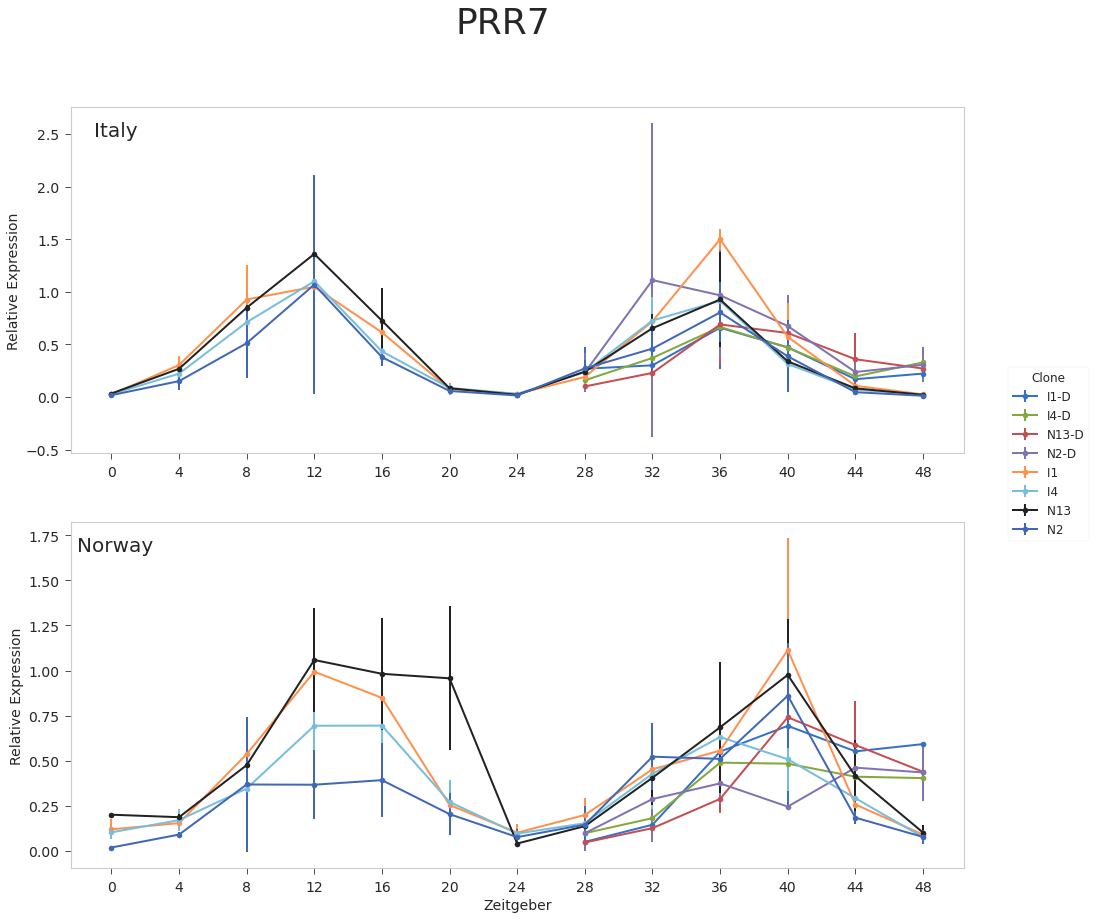

In [98]:
plot_gene(data2, 'PRR7')

In [99]:
treatment_ttest(data2, 'PRR7')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
zeitgeber Clone                     
0         I4      3.206273  0.032705
          N13    53.694561  0.000014
8         I4     -5.755585  0.004519
          N13    -6.872797  0.006308
20        I1      2.835010  0.047105
24        I4      3.931264  0.029305
36        I1     -9.383326  0.002564
40        N13     3.412662  0.042068
44        I4      2.939402  0.042414
          N13     2.871472  0.045401
          N2      6.239368  0.003362
48        I1      3.272967  0.030703
          N13     3.139629  0.034860
          N2      2.887123  0.044692

In [100]:
dark_italy_ttest(data2, 'PRR7')

,,Ttest_ind,p-value
zeitgeber,Clone,,


In [101]:
clone_ttest(data2, 'PRR7')

,,Ttest_ind,p-value
zeitgeber,treatment,,
24,Italy,3.431946,0.013938
36,D-Norway,2.565645,0.030404


## TOC1

(<Figure size 1152x1008 with 2 Axes>,
 (<AxesSubplot:title={'center':'Italy'}, ylabel='Relative Expression'>,
  <AxesSubplot:title={'center':'Norway'}, xlabel='Zeitgeber', ylabel='Relative Expression'>))

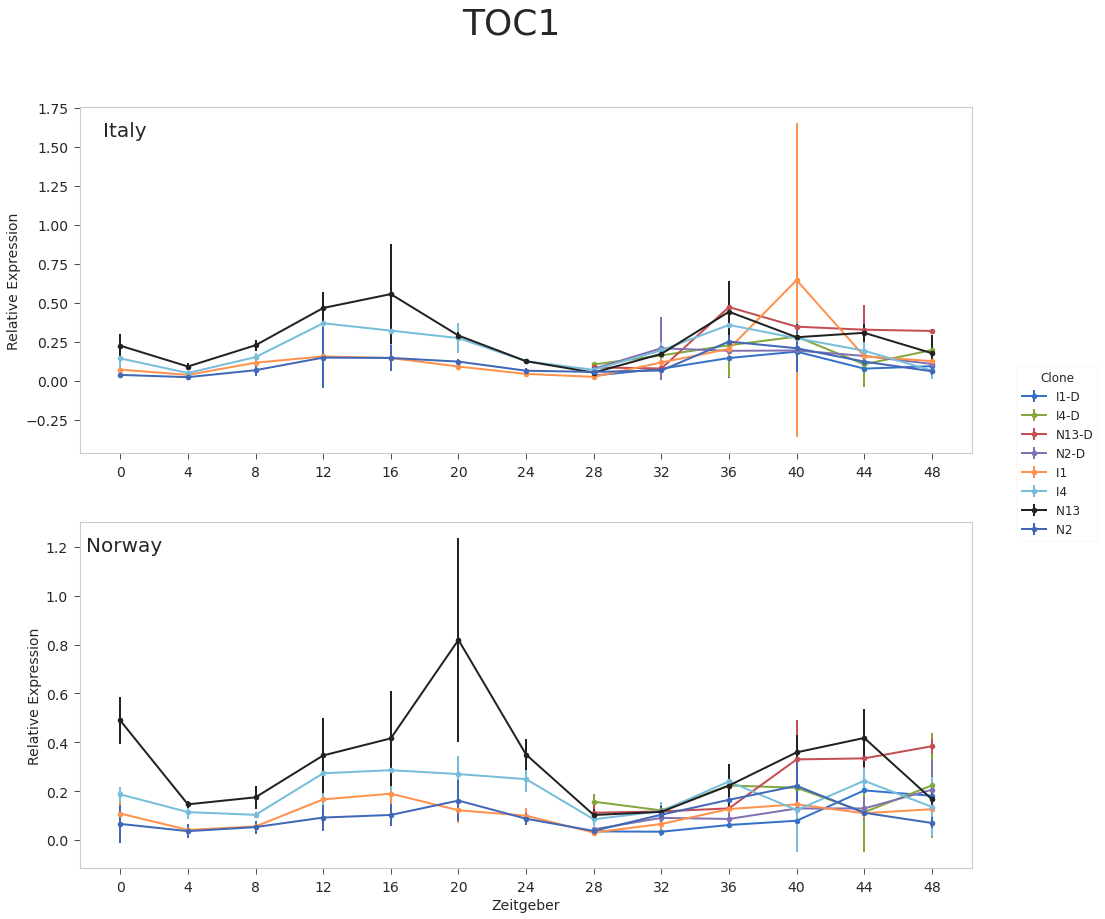

In [102]:
plot_gene(data2, 'TOC1')

In [103]:
treatment_ttest(data2, 'TOC1')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
zeitgeber Clone                     
0         N13     3.527725  0.038702
4         I4      4.330312  0.022711
          N13     3.487859  0.039828
8         I4     -3.135233  0.035008
24        I4      3.220491  0.048566
36        I4     -5.140719  0.035819

In [104]:
dark_italy_ttest(data2, 'TOC1')

,,Ttest_ind,p-value
zeitgeber,Clone,,


In [105]:
clone_ttest(data2, 'TOC1')

,,Ttest_ind,p-value
zeitgeber,treatment,,


## LUX

(<Figure size 1152x1008 with 2 Axes>,
 (<AxesSubplot:title={'center':'Italy'}, ylabel='Relative Expression'>,
  <AxesSubplot:title={'center':'Norway'}, xlabel='Zeitgeber', ylabel='Relative Expression'>))

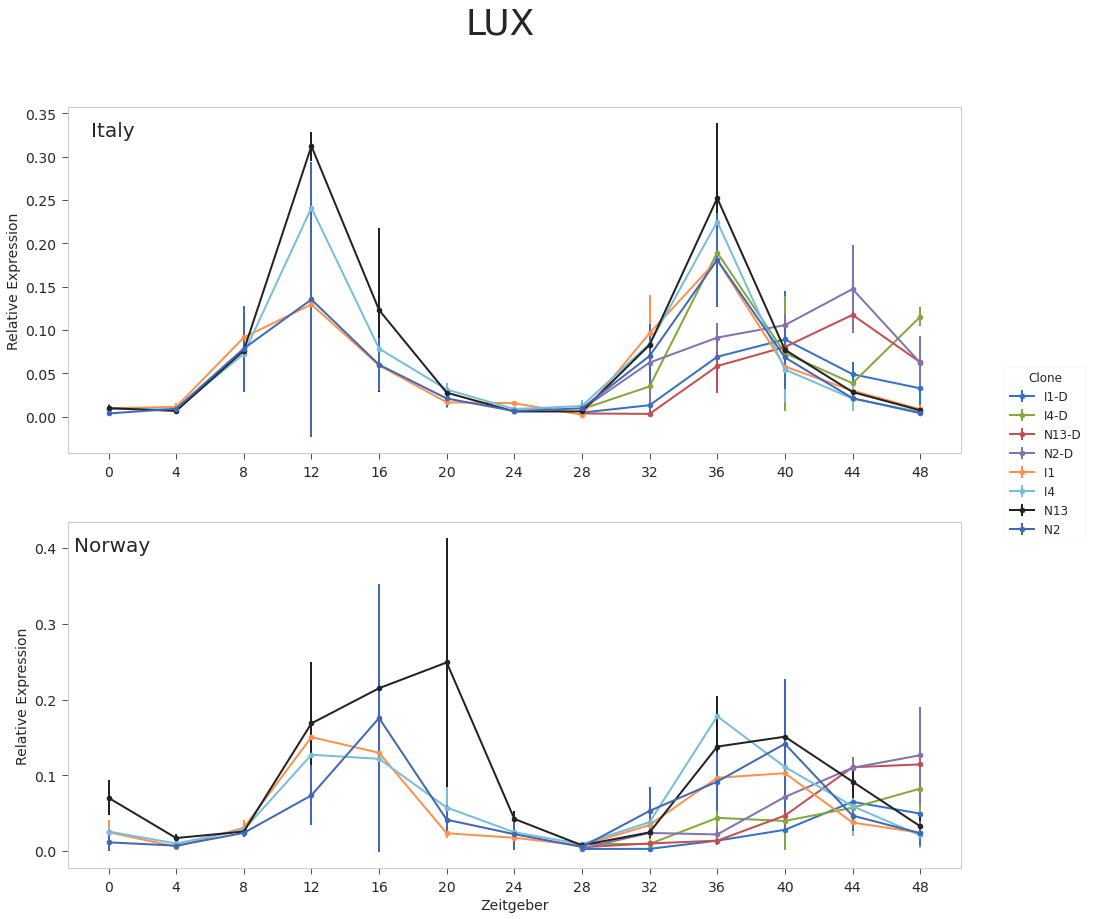

In [106]:
plot_gene(data2, 'LUX')

In [107]:
treatment_ttest(data2, 'LUX')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
zeitgeber Clone                     
0         I4      3.980154  0.016399
          N13     4.930581  0.015993
8         I4    -20.326466  0.000035
12        N13    -2.992537  0.040237
24        I4      4.909113  0.016185
32        N13    -8.458499  0.003469
40        N13     3.453612  0.040829
44        N13     5.053506  0.007213
48        N13     2.895928  0.044299

In [108]:
dark_italy_ttest(data2, 'LUX')

,,Ttest_ind,p-value
zeitgeber,Clone,,


In [109]:
clone_ttest(data2, 'LUX')

Ttest_ind   p-value
zeitgeber treatment                     
24        Italy       2.630628  0.039027
44        D-Italy    -3.731456  0.007345
          D-Norway   -3.175241  0.011271

## PRDX

(<Figure size 1152x1008 with 2 Axes>,
 (<AxesSubplot:title={'center':'Italy'}, ylabel='Relative Expression'>,
  <AxesSubplot:title={'center':'Norway'}, xlabel='Zeitgeber', ylabel='Relative Expression'>))

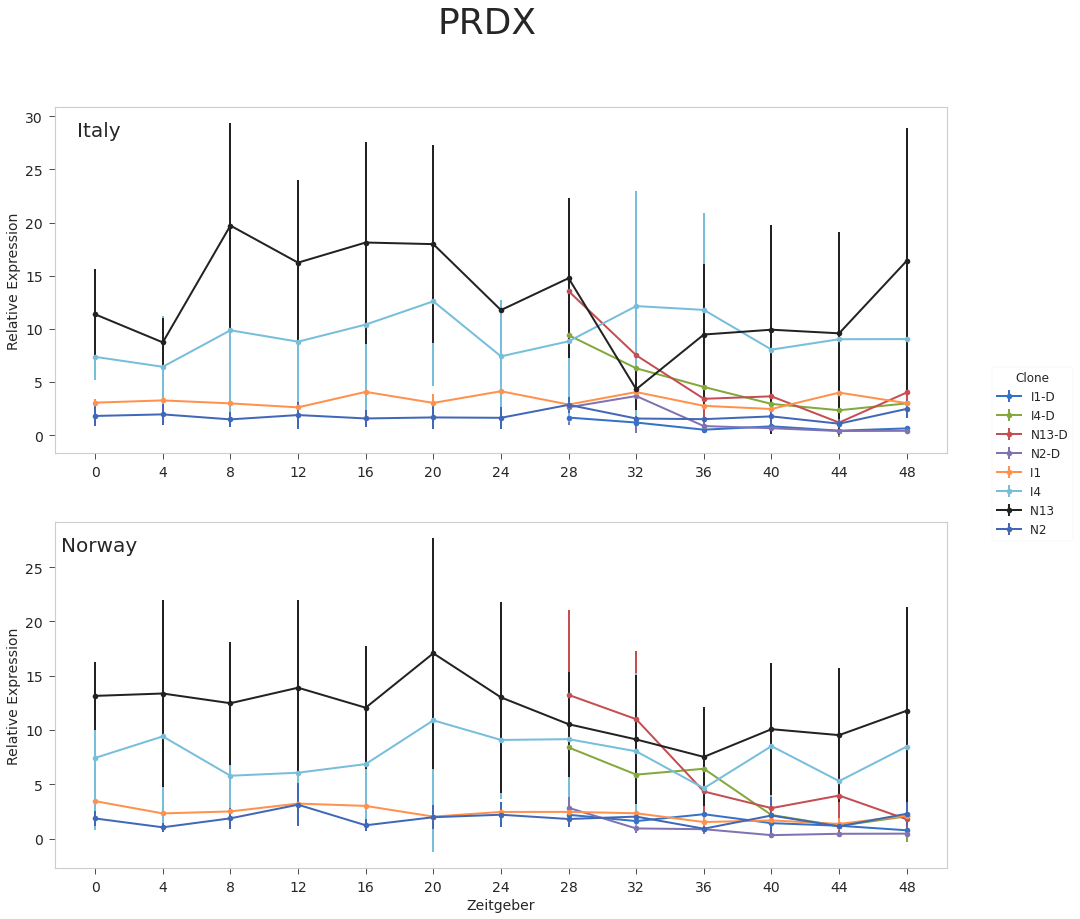

In [110]:
plot_gene(data2, 'PRDX')

In [111]:
treatment_ttest(data2, 'PRDX')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
zeitgeber Clone                     
24        I1     -3.436427  0.041344
36        I1     -3.304165  0.045591
          N2     -4.019756  0.027649

In [112]:
dark_italy_ttest(data2, 'PRDX')

,,Ttest_ind,p-value
zeitgeber,Clone,,


In [113]:
clone_ttest(data2, 'PRDX')

,,Ttest_ind,p-value
zeitgeber,treatment,,


## PRR5

(<Figure size 1152x1008 with 2 Axes>,
 (<AxesSubplot:title={'center':'Italy'}, ylabel='Relative Expression'>,
  <AxesSubplot:title={'center':'Norway'}, xlabel='Zeitgeber', ylabel='Relative Expression'>))

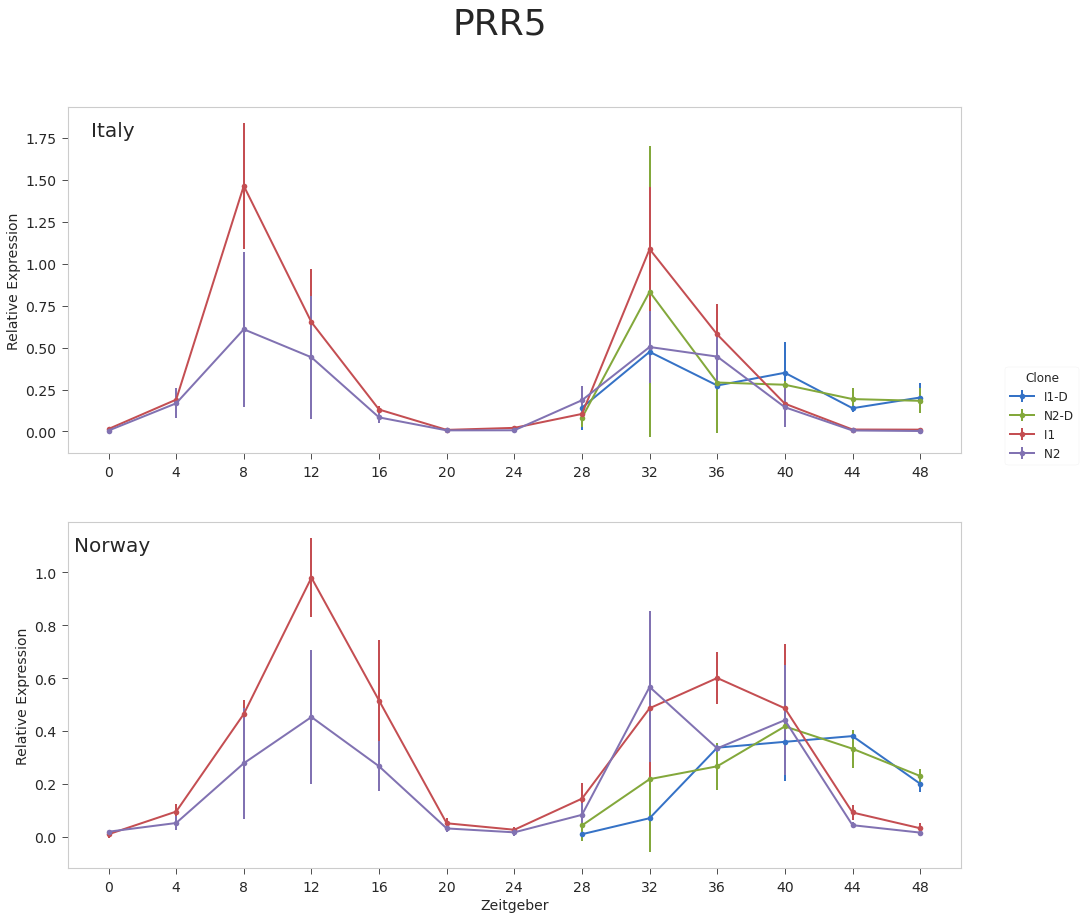

In [114]:
plot_gene(data2, 'PRR5')

In [115]:
treatment_ttest(data2, 'PRR5')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
zeitgeber Clone                     
4         I1     -4.628781  0.018990
8         I1     -4.558572  0.010350
16        I1      2.921407  0.043183
          N2      3.338021  0.044453
20        I1      3.794865  0.019188
          N2      3.111092  0.035834
44        N2      5.941193  0.004025

In [116]:
dark_italy_ttest(data2, 'PRR5')

,,Ttest_ind,p-value
zeitgeber,Clone,,


In [117]:
clone_ttest(data2, 'PRR5')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,,Ttest_ind,p-value
zeitgeber,treatment,,
36,Norway,3.664038,0.035146
44,Italy,3.386919,0.042872
